# Domain adaptation

In [12]:
import random
import collections

import aim
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from os import makedirs, listdir, environ
from os.path import join, isdir
from typing import Optional, Tuple, Union, Dict, List

from shutil import copytree
from pathlib import Path

from torch.utils.data import DataLoader, random_split, Dataset
from torch.utils.data.dataset import Subset
from torch.optim import lr_scheduler, SGD, Adam, Optimizer
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
from torchvision import models

from IPython.display import clear_output

In [13]:
DATASET_ZIP_PATH = '/tmp/Adaptiope.zip'
DATASET_EXTRACTION_PATH = '/tmp/Adaptiope'
DATASET_PATH = Path('./data/adaptiope_small')

BEST_PR_MODEL_PATH = './data/best_pr.pth'
BEST_RP_MODEL_PATH = './data/best_rp.pth'
#BEST_PR_MODEL_PATH = './data/tmp_pr.pth'
#BEST_RP_MODEL_PATH = './data/tmp_rp.pth'

## Dataset extraction

TODO

In [14]:
!mkdir -p {DATASET_EXTRACTION_PATH}
!unzip -d {DATASET_EXTRACTION_PATH} {DATASET_ZIP_PATH}

unzip:  cannot find or open /tmp/Adaptiope.zip, /tmp/Adaptiope.zip.zip or /tmp/Adaptiope.zip.ZIP.


In [15]:
classes = ["backpack", "bookcase", "car jack", "comb", "crown", "file cabinet", "flat iron", "game controller", "glasses",
               "helicopter", "ice skates", "letter tray", "monitor", "mug", "network switch", "over-ear headphones", "pen",
               "purse", "stand mixer", "stroller"]

if not isdir(DATASET_PATH):
    for d, td in zip([
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/product_images",
        f"{DATASET_EXTRACTION_PATH}/Adaptiope/real_life"],[
        f"{DATASET_PATH}/product_images",
        f"{DATASET_PATH}/real_life"]):
        makedirs(td)
        for c in classes:
            c_path = join(d, c)
            c_target = join(td, c)
            copytree(c_path, c_target)

## Dataset exploration

The Adaptiope dataset has been developed as a benchmark for Unsupervised Domain Adaptation (UDA), which consists in learning a model given a labelled source domain and an unlabelled target domain.
Adaptiope contains three different domains, but for the sake of this assignment, only product and real life images have been used.
Each domains contains the same 123 classes, each one with exactly 100 samples: only 20 classes will be used for this assignment.
Images are stored with arbitrary dimensions: some cropping and resizing operations are required to be able to input them in a Imagenet-pretrained model which accepts only 224x224 images.

In [5]:
dataset = ImageFolder(DATASET_PATH / "product_images")
idx_to_class = {v: k for k,v in dataset.class_to_idx.items()}

In [6]:
# imgs: List[str, int] path, class
seen_classes = set()
imgs = []
for i, (p, c) in enumerate(dataset.imgs):
    if c not in seen_classes:
        seen_classes.add(c)
        imgs.append(i)

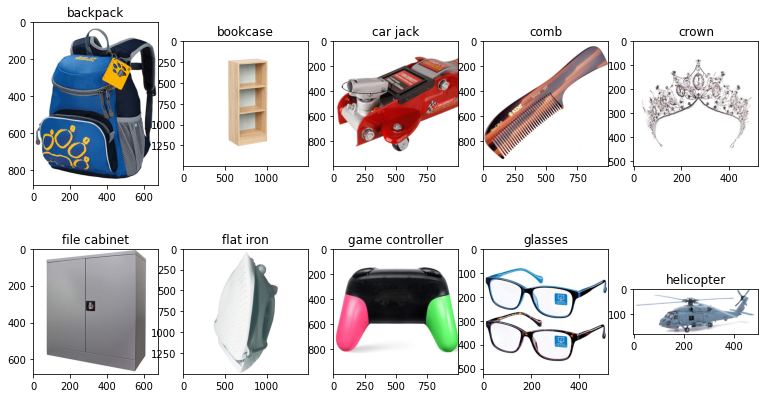

In [7]:
fig, axs = plt.subplots(2, 5, figsize=(13,7))
for i in range(2):
    for j in range(5):
        image, title = dataset[imgs.pop(0)]
        axs[i,j].imshow(image)
        axs[i,j].set_title(idx_to_class[title])
plt.show()        

## Utility functions

In [8]:
def set_random_seed(seed: int=0) -> None:
    """
    Sets random seed for Python, Numpy and PyTorch
    
    Parameters
    ----------
    seed: int
        seed used for the initialization
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    """
    Inspects if there is a GPU avaible and returns it
    
    Returns
    -------
    torch.device
        torch initialized device
    """
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def print_epoch_chart(
    train_losses: List[float],
    val_losses: List[float],
    train_acc: List[float],
    val_acc: List[float],
    epoch: int,
    num_epochs: int
) -> None:
    """
    Given train information create and display two plots about the training process
    It supports automatic cleaning of the cell output.
    
    Parameters
    ----------
    train_losses: List[float]
        list of losses during epochs
    val_losses: List[float]
        list of losses during epochs
    train_acc: List[float]
        list of accuracies during epochs
    val_acc: List[float]
        list of accuracies during epochs
    epoch: int
        current epoch
    num_epochs: int
        total number of epochs
    """
    clear_output(wait=True)
    
    fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(15,7))
    x = np.arange(len(train_losses))
    loss_ax.plot(x, train_losses, label='train')
    loss_ax.plot(x, val_losses, label='validation')
    loss_ax.set_title("Loss")
    loss_ax.set_ylim([0, 5])
    loss_ax.legend()
    acc_ax.plot(x, train_acc, label='train')
    acc_ax.plot(x, val_acc, label='validation')
    acc_ax.set_title("Accuracy")
    acc_ax.legend()
    fig.suptitle(f"Epoch {epoch+1} of {num_epochs}")
    plt.show()

## Models

All models are composed by three main elements:

- backbone
- feature processor (optional)
- classifier

The backbone is a pretrained network from `torchvision`: it is going to be finetuned with a smaller learning rate with respect to the one used for other two components.

The feature extractor is used for process the output of the backbone. We decided to separate these two steps into two classes in order to have more control on both of them, allowing us to make tests with many combinations.

The last component is the classifier. It is a simple linear layer that takes the output of the backbone (or feature processor, if it is used) and returns the probability of the sample of belonging to a certain class.

In [9]:
class Backbone(nn.Module):
    """
    Pre-trained torchvision model wrapper
    
    Attributes
    ----------
    backbone: torchvision.models
        pre-trained torchvision model
    output_num: int
        number of features returned by the backbone
    """
    def __init__(
        self,
        backbone_type: str,
    ) -> None:
        super(Backbone, self).__init__()
        if backbone_type == "resnet18":
            self.backbone = models.resnet18(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()        
        elif backbone_type == "resnet34":
            self.backbone = models.resnet34(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()
        elif backbone_type == "resnet50":
            self.backbone = models.resnet50(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()
        elif backbone_type == "resnet101":
            self.backbone = models.resnet101(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()
        elif backbone_type == "resnet152":
            self.backbone = models.resnet152(pretrained=True)
            self.output_num = self.backbone.fc.in_features
            self.backbone.fc = nn.Sequential()
        else:
            raise ValueError("select one valid backbone_type")
            
        
    def get_output_num(self) -> int:
        """
        Returns the number of features returned by the model
        
        Returns
        -------
        int
            number of features
        """
        return self.output_num
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Applies the model to the passed input
        
        Parameters
        ----------
        x: torch.tensor
            input of the model
        
        Returns
        -------
        torch.tensor
            output of the model
        """
        return self.backbone(x)


class FeatureProcessor(nn.Module):
    """
    Features processor of the output of a pre-trained torchvision model
    
    Attributes
    ----------
    processing_layer: nn.Sequential
        torch sequential layer
    output_num: int
        number of features returned by the processor
    """
    def __init__(self, input_size: int, layer_sizes: Tuple[int]) -> None:
        super(FeatureProcessor, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, layer_sizes[0]))
        layers.append(nn.ReLU())
        for i in range(len(layer_sizes[1:])):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nn.ReLU())
        self.processing_layer = nn.Sequential(*layers)
        self.output_num = layer_sizes[-1]
        
    def get_output_num(self) -> int:
        """
        Returns the number of features returned by the model
        
        Returns
        -------
        int
            number of features
        """
        return self.output_num
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Applies the model to the passed input
        
        Parameters
        ----------
        x: torch.tensor
            input of the model
        
        Returns
        -------
        torch.tensor
            output of the model
        """
        return self.processing_layer(x)


class Classifier(nn.Module):
    """
    Final classifier that takes processed features and computes predictions

    Attributes
    ----------
    backbone: torchvision.models
        torchvision pre trained model
    processing_features: bool
        flag that indicates if feature processor is used
    processing_layer: Optional[FeatureProcessor]
        optional feature processor
    classification_layer: nn.Linear
        linear layer used to map processed features to predictions
    output_num: int
        number of features returned by the processor
    """
    def __init__(
        self,
        backbone_type: str,
        n_classes: int,
        n_feature_extracted: Optional[Tuple[int]] = None
    ) -> None:
        super(Classifier, self).__init__()
        self.backbone = Backbone(backbone_type)
        if n_feature_extracted:
            self.processing_features = True
            self.processing_layer = FeatureProcessor(self.backbone.get_output_num(), n_feature_extracted)
        else:
            self.processing_features = False
        self.classification_layer = nn.Linear(
            self.processing_layer.get_output_num() if self.processing_features else self.backbone.get_output_num(),
            n_classes
        )
        self.output_num = n_classes
        
    def get_output_num(self) -> int:
        """
        Returns the number of features returned by the model
        
        Returns
        -------
        int
            number of features
        """
        return self.output_num
        
    def get_features(self, x: torch.tensor) -> torch.tensor:
        """
        Computes and returns features
        
        Parameters
        ----------
        x: torch.tensor
            input of processing layer
        
        Returns
        -------
        torch.tensor
            output of processing layer
        """
        features = self.backbone(x)
        if self.processing_features:
            features = self.processing_layer(features)
        return features
        
    def forward(self, x: torch.tensor) -> Tuple[torch.tensor, torch.tensor]:
        """
        Applies the model to the passed input
        
        Parameters
        ----------
        x: torch.tensor
            input of the model
        
        Returns
        -------
        torch.tensor
            output of the model
        """
        features = self.get_features(x)
        classes = self.classification_layer(features)
        
        return features, classes
    

class DomainAdaptationModel(nn.Module):
    """
    Final classifier that takes processed features and computes predictions using domain adaptation.

    Attributes
    ----------
    backbone: torchvision.models
        torchvision pre trained model
    processing_features: bool
        flag that indicates if feature processor is used
    processing_layer: Optional[FeatureProcessor]
        optional feature processor
    classification_layer: nn.Linear
        linear layer used to map processed features to predictions
    output_num: int
        number of features returned by the processor
    """
    def __init__(
        self,
        backbone_type: str,
        n_classes: int,
        n_feature_extracted: Optional[Tuple[int]] = None
    ) -> None:
        super(DomainAdaptationModel, self).__init__()
        self.backbone = Backbone(backbone_type)
        if n_feature_extracted:
            self.processing_features = True
            self.processing_layer = FeatureProcessor(self.backbone.get_output_num(), n_feature_extracted)
        else:
            self.processing_features = False
        """
        self.batch_normalization_layers = {
            'source': nn.BatchNorm1d(self.processing_layer.get_output_num()),
            'target': nn.BatchNorm1d(self.processing_layer.get_output_num()),
        }
        """
        self.classification_layer = nn.Linear(
            self.processing_layer.get_output_num() if self.processing_features else self.backbone.get_output_num(),
            n_classes
        )
        self.output_num = n_classes

    def get_output_num(self) -> int:
        return self.output_num
        
    def get_features(self, x: torch.tensor) -> torch.tensor:
        features = self.backbone(x)
        if self.processing_features:
            features = self.processing_layer(features)
        return features
        
    def forward(self, x: torch.tensor, dataset_name: str=None) -> torch.tensor:
        """
        Applies the model to the passed input
        
        Parameters
        ----------
        x: torch.tensor
            input of the model
        dataset_name: str
            dataset domain to use
        
        Returns
        -------
        torch.tensor
            output of the model
        """
        features = self.get_features(x)
        # normalized = self.batch_normalization_layers[dataset_name](features)
        classes = self.classification_layer(features)
        
        # TODO: understand if we want to return normalized features instead of features
        return features, classes

## Dataset

In [10]:
class SingleDataSourceDataset(Dataset):
    """
    Wrapper for PyTorch Dataset
    
    Attributes
    ----------
    inner_dataset: Dataset
        inner dataset of pytorch
    name: str
        name of the dataset, allowed names: source and target
    class_to_idx: Dict[str, int]
        class string name to index
    classees_indexes: np.ndarray
        list of samples for each class
    num_classes: int
        number of classes in the dataset
    """
    def __init__(
        self,
        dataset_subset: Dataset,
        name: str, 
    ):
        self.inner_dataset = dataset_subset
        if name not in ["source", "target"]:
            raise ValueError("Dataset name must be either source or target")
        self.name = name
        self.class_to_idx = self.inner_dataset.class_to_idx
        self.class_indexes = np.array([class_id for _, class_id in self.inner_dataset.samples])
        self.num_classes = len(self.inner_dataset.classes)
        
    def get_name(self) -> str:
        """
        Returns the dataset name
        
        Returns
        -------
        str
            name of the dataset
        """
        return self.name

    def __len__(self):
        return len(self.inner_dataset)

    def __getitem__(self, idx):
        return self.inner_dataset[idx]


class CANDataset(Dataset):
    # TODO: remove classes_per_batch
    """
    Custom dataset for Contrastive Adaptation Network.
    It can be indexed by class indexes and returns samples_per_class samples.
    
    Attributes
    ----------
    source_dataset: SingleDataSourceDataset
        source domain dataset
    target_dataset: SingleDataSourceDataset
        target domain dataset
    samples_per_class: int
        number of samples to return for each dataset entry
    filter_mask: np.ndarray
        valid inner datasets indexes based on the clustering result 
    target_clustering_labels: np.ndarray
        labels obtained by applying the clustering algorithm on the taget domain
    """
    def __init__(
        self,
        source_dataset: SingleDataSourceDataset,
        target_dataset: SingleDataSourceDataset,
        samples_per_class: int,
        classes_per_batch: int,
        filter_mask: np.ndarray,
        target_clustering_labels: np.ndarray,
    ):
        self.source_dataset = source_dataset
        self.target_dataset = target_dataset
        assert len(self.source_dataset) == len(self.target_dataset), "Number of classes must be the same for source and target dataset"
        
        self.num_classes = self.source_dataset.num_classes
        self.samples_per_class = samples_per_class
        self.classes_per_batch = classes_per_batch
        self.target_clustering_labels = target_clustering_labels
        
        self.source_class_indexes = [
            np.argwhere(
                self.source_dataset.class_indexes == idx
            ).squeeze() for idx in range(self.num_classes)
        ]

        self.target_class_indexes = [
            np.argwhere(
                self.target_clustering_labels == idx
            ).squeeze() for idx in range(self.num_classes)
        ] 
        valid_indexes = np.argwhere(filter_mask == True).flatten()
        for idx in range(self.num_classes):
            self.target_class_indexes[idx] = self.target_class_indexes[idx][
                np.isin(self.target_class_indexes[idx], valid_indexes)
            ]
        
    def __len__(self):
        return self.num_classes
    
    def __getitem__(self, idx):
        source_idxs = np.random.choice(
            self.source_class_indexes[idx],
            size=self.samples_per_class, 
            replace=True
        )
        target_idxs = np.random.choice(
            self.target_class_indexes[idx],            
            size=self.samples_per_class, 
            replace=True
        )
        source_samples = [self.source_dataset[i] for i in source_idxs]
        source_xs = torch.tensor([sample[0].numpy() for sample in source_samples])
        source_ys = torch.tensor([sample[1] for sample in source_samples])
        target_xs = torch.tensor([self.target_dataset[i][0].numpy() for i in target_idxs])
        target_ys = torch.tensor(self.target_clustering_labels[target_idxs])
        
        return {
            'source_xs': source_xs,
            'source_ys': source_ys,
            'target_xs': target_xs,
            'target_ys_clustering': target_ys,
        }
    
def CAN_collate_function(data):
    """
    Custom collate function for CAN dataloader.
    
    Parameters
    ----------
    data: torch.tensor
        input of the model
        
    Returns
    -------
    Dict[str, torch.tensor]
        output of the dataloader
    """
    return {
        'source_xs': torch.cat([c['source_xs'] for c in data]),
        'source_ys': torch.cat([c['source_ys'] for c in data]),
        'target_xs': torch.cat([c['target_xs'] for c in data]),
        'target_ys_clustering': torch.cat([c['target_ys_clustering'] for c in data]),
    }

In [11]:
SplitRule = collections.namedtuple('SplitRule', ['train', 'test'])

def get_split(
    path: str,
    split: SplitRule,
    dataset_name: Optional[str]=None
) -> Tuple[SingleDataSourceDataset, SingleDataSourceDataset]:
    """
    Returns a standard dataloader applied on the given dataset
    
    Parameters
    ----------
    path: str
        dataset path
    split: SplitRule
        percentages for train and test set size
    dataset_name: str
        name to assign to the dataset

    Returns
    -------
    SingleDataSourceDataset
        train dataset
    SingleDataSourceDataset
        test dataset
    """

    train_filter = set()
    test_filter = set()

    for image_class in listdir(path):
        files = list(map(lambda x: str(path / image_class / x), listdir(path / image_class)))
        train_split, test_split = random_split(files, [int(len(files)*split.train), int(len(files)*split.test)])
        train_split = {files[i] for i in train_split.indices}
        test_split = {files[i] for i in test_split.indices}

        train_filter = train_filter.union(train_split)
        test_filter = test_filter.union(test_split)
        
    transform = T.Compose([
        #T.Resize(256),
        #T.RandAugment(),
        T.Resize((256, 256)),
        T.CenterCrop((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    train_dataset = ImageFolder(
        path,
        transform=transform,
        is_valid_file=lambda x: x in train_filter
    )
    test_dataset = ImageFolder(
        path,
        transform=transform,
        is_valid_file=lambda x: x in test_filter
    )
    return (SingleDataSourceDataset(train_dataset, dataset_name),
            SingleDataSourceDataset(test_dataset, dataset_name))

def get_data_loader(dataset: Dataset, batch_size: int, num_threads: int) -> DataLoader:
    """
    Returns a standard dataloader applied on the given dataset
    
    Parameters
    ----------
    dataset: Dataset
        dataset to include in the dataloader
    batch_size: int
        size of the batch for the dataloader
    num_threads: int
        number of threads to access to the dataloader

    Returns
    -------
    DataLoader
        dataloader on the given dataset
    """
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_threads
    )

def get_optimizer(model: nn.Module, lr: float, wd: float, momentum: float, optimizer_name: str="SGD") -> Optimizer:
    """
    Returns the optimizer for the given network.
    The backbone model uses lr/10 as its learning rate.
    
    Parameters
    ----------
    model: nn.Module
        model to optimize
    lr: float
        optimizer learning rate
    wd: float
        optimizer weight decay
    momentum:
        optimizer momentum

    Returns
    -------
    Optimizer
        optimizer on the given network using given parameters
    """
    
    higher_lr_weights = []
    lower_lr_weights = []

    for name, param in model.named_parameters():
        if name.startswith('backbone'):
            lower_lr_weights.append(param)
        elif name.startswith('processing') or name.startswith('classification'):
            higher_lr_weights.append(param)
        else:
            raise ValueError(f"Unexpected type of weights {name}")

    if optimizer_name == "SGD":
        optimizer = torch.optim.SGD(
            [
                {'params': lower_lr_weights},
                {'params': higher_lr_weights, 'lr': lr}
            ],
            lr=lr / 10,
            weight_decay=wd,
            momentum=momentum
        )
    elif optimizer_name == "Adam":
        optimizer = torch.optim.Adam(
            [
                {'params': lower_lr_weights},
                {'params': higher_lr_weights, 'lr': lr}
            ],
            lr=lr / 10,
            weight_decay=wd,
        )
    else:
        raise ValueError(f"Unexpected optimizer {optimizer_name}")
        

    return optimizer

In [12]:
product_path = DATASET_PATH / "product_images"
real_path = DATASET_PATH / "real_life"

split_rule = SplitRule(0.8, 0.2)

## Baseline

The `Baseline` class contains all components for train and test the model without domain adaptation.
As described in the models section, a model is split into backbone, feature processor and classifier.
As backbones used for the baseline, `ResNet` 18, 34, 50, 101, 152 have been used.
We decided to use the ResNet architecture since:
- it is a benchmark in the literature;
- it has some interesting and functional design choices: convolutional layers compose the majority of the learnable parameters in the network, and the number of linear layers are reduced as much as possible. This fact is useful when applying domain adaptation, since there are less parameters to tweak;
- there are many available pretrained models in ImageNet dataset that can be used as a starting point for the training procedure.

The following table presents some accuracy results on different `ResNet` models. The goal of this study is to have a good trade-off between accuracy and training/inference time: for this reason we have chosen the ResNet34 for some hyperparams finetuning and the ResNet50 for the domain adaptation training procedure.

| ResNet depth |  P -> P  |  R -> R   |  P -> R   |  R -> P   |
|--------------|----------|-----------|-----------|-----------|
| 18           |  0.96    |  0.875    |  0.7775   |  0.915    |
| 34           |  0.975   |  0.92     |  0.8375   |  0.9275   |
| 50           | **0.98** |  0.9225   |  0.8675   |  0.9325   |
| 101          |  0.75    |  0.9225   |  0.8625   |  0.8350   |
| 152          |  0.9775  | **0.965** | **0.885** | **0.965** |

Moreover, different approaches for data augmentation and image modification have been inspected to seek any performance improvement. Some of the approaches that have been tested are:

- resize(256) instead of resized(256,256) in order to avoid an alteration of the proportion of images;
- auto augmentation provided by torchvision based on the ImageNet preset;
- random augmentation provided by torchvision;

The results are described in the following table:

| Transformation      | P -> P | R -> R | P -> R | R -> P | 
|---------------------|--------|--------|--------|--------|
| resize 256 256      | 0.9675 | 0.92   | 0.8325 | 0.93   |
| resize 256          | 0.9675 | 0.92   | 0.8525 | 0.92   |
| auto augmentaion    | 0.96   | 0.92   | 0.8075 | 0.925  |
| random augmentation | 0.9625 | 0.915  | 0.8525 | 0.925  |

Since there is no  big improvement in terms of accuracy, we did not consider any particular data augmentation techniques.

To improve performance, some attempts to increase the number of epochs and to introduce a scheduler to manage the learning rate dynamically have been made.
Unfortunately, these two tests did not bring improvement on the accuracy.

TODO: qui fare l'esempio dell'ascia e del central crop, inoltre forse per giustificare questa affermazione sarebbe carino avere le matrici con le accuracy per ogni classe e mostrare come certi tipi di augmentation migliorano in certi tipi di immagini e in altri no

Another test considered the possibility to add some linear layers for the processing the features extracted by the ResNet, increasing the so-called model capacity. The following table presents the result achieved on ResNet50:

| Number of processing layers | P -> P | R -> R | P -> R | R -> P | 
|-----------------------------|--------|--------|--------|--------|
| 1 (1024)                    | 0.9775 | 0.94   | 0.8625 | 0.9425 |
| 2 (2048->1024)              | 0.9725 | 0.9    | 0.8525 | 0.9275 |
| 3 (1024->2048->1024)        | 0.9775 | 0.9175 | 0.85   | 0.935  |
| 4 (1024->2048->1024->512)   | 0.97   | 0.9175 | 0.8075 | 0.9125 |

TODO: vedere se ha senso provare e parlare della batch normalization differente per ogni dataset qui o nel ccd

In [13]:
class Baseline:
    """
    Baseline solver for the domain adaptation task, it includes all elements required for train and test.
    This base class does not include any domain adaptation procedure.

    Attributes
    ----------
    device: torch.device
        device on which the computation is done
    source_path: str
        source dataset path
    destination_path: str
        target dataset path
    split_rule: SplitRule
        rule used to split the dataset into train and test
    num_epochs: int
        number of epochs for train phase
    batch_size: int
        batch size used for dataloaders
    criterion:
        criterion used for the loss value computation
    num_threads: int
        number of threads used by torch
    domain_adaptation_loss_weight: float
        weight of special loss used to improve the domain adaptation
    dataloaders: Dict[str, Dict[str, DataLoader]]
        dataloaders used for train and test, both for source and target dataset
    source_test_dataset: SingleDataSourceDataset
        source domain test dataset
    target_test_dataset: SingleDataSourceDataset
        target domain test dataset
    num_classes: int
        number of classes of the task
    model: torch.nn.Module
        deep learning model
    optimizer:
        optimizer used for the train phase
    scheduler:
        scheduler used to regulate the learning rate during the train
    aim_session: aim.Run
        aim session used for metrics tracking
    """
    def __init__(
        self,
        source_path: str,
        target_path: str,
        split_rule: SplitRule,
        num_epochs: int,
        batch_size: int,
        criterion,
        lr: float,
        weight_decay: float,
        momentum: float,
        num_threads: int,
        experiment_name: str,
        run_hash: str,
        domain_adaptation_loss_weight: float,
    ):
        self.device = get_device()
        self.source_path = source_path
        self.target_path = target_path   
        self.split_rule = split_rule
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = criterion
        self.num_threads = num_threads
        self.domain_adaptation_loss_weight = domain_adaptation_loss_weight
        
        self.dataloaders, self.source_test_dataset, self.target_test_dataset, self.num_classes = self._init_dataloaders()
        self.model = Classifier("resnet50", self.num_classes)
        self.optimizer = get_optimizer(self.model, lr, weight_decay, momentum)
        self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=15, gamma=0.1)
        
        self.experiment_name = experiment_name
        self.run_hash = run_hash

        self.model.to(self.device)
        
    def _init_dataloaders(self) -> Tuple[Dict[str, Dict[str, DataLoader]], SingleDataSourceDataset, SingleDataSourceDataset, int]:
        """
        Build the datasets and dataloaders for the training loop.
        
        Returns
        ----------
        Dict[str, Dict[str, DataLoader]]:
            dataloaders for train dataset (both source and target domains) and test dataset (just source domain)
        SingleDataSourceDataset:
            source test dataset
        SingleDataSourceDataset:
            target test dataset
        int:
            number of classes
        """
        source_train, source_test = get_split(self.source_path, self.split_rule, "source")
        target_train, target_test = get_split(self.target_path, self.split_rule, "target")
        dataloaders = {
            'train': {
                'source': get_data_loader(source_train, batch_size, num_threads),
                'target': get_data_loader(target_train, batch_size, num_threads),
            },
            'test': {
                'source': get_data_loader(source_test, batch_size, num_threads),
            }
        }
        return dataloaders, source_test, target_test, source_train.num_classes
    
    def _compute_accuracy(
        self,
        reals: torch.tensor,
        predictions: torch.tensor,
    ) -> float:
        """
        Compute the accuracy comparing ground truth and predictions
        
        Parameters
        ----------
        reals: torch.tensor
            ground truth labels
        predictions: torch.tensor
            model predictions
        
        Returns
        ----------
        float:
            model prediction accuracy
        """
        return (torch.argmax(predictions, 1) == reals).sum().item() / reals.size()[0]
    
    def _compute_domain_adaptation_loss(
        self,
        features_source: torch.tensor,
        features_target: torch.tensor,
    ) -> Optional[float]:
        """
        Compute the domain adaptation loss component for discrepancy-based techniques
        
        Parameters
        ----------
        features_source: torch.tensor
            features extracted by the model on the source domain
        features_target: torch.tensor
            features extracted by the model on the target domain
        """
        return None
    
    def _train_step(self) -> Tuple[float, float]:
        loss = 0.0
        acc = 0.0
        iter_dataloader_target_train = iter(self.dataloaders['train']['target'])
        for i, (x_source, labels_source) in enumerate(self.dataloaders['train']['source']):
            x_target, _ = next(iter_dataloader_target_train)
            x_target = x_target.to(self.device)
            x_source = x_source.to(self.device)
            labels_source = labels_source.to(self.device)
            
            self.optimizer.zero_grad()
            with torch.autocast(device_type=self.device.type):
                features_source, predictions_source = self.model(x_source)
                features_target, predictions_target = self.model(x_target)
                x_source = x_source.detach().cpu()
                
                batch_loss = self.criterion(predictions_source, labels_source)
                predictions_source = predictions_source.detach().cpu()
                labels_source = labels_source.detach().cpu()
                acc += self._compute_accuracy(labels_source, predictions_source)
                
                domain_adaptation_loss = self._compute_domain_adaptation_loss(
                    features_source,
                    features_target,
                )
                if domain_adaptation_loss is not None:
                    batch_loss += domain_adaptation_loss * self.domain_adaptation_loss_weight
                batch_loss.backward()
                loss += batch_loss.item()
                
                self.optimizer.step()
                
        loss /= len(self.dataloaders['train']['source'])
        acc /= len(self.dataloaders['train']['source'])
        
        return loss, acc
    
    def _validation_step(self) -> Tuple[float, float]:
        """
        Returns the loss and accuracy over the source domain test dataset
        
        Returns
        ----------
        float
            model loss over the source domain test dataset 
        float
            model accuracy over the source domain test dataset 
        """
        loss = 0.0
        acc = 0.0
        for i, (x, labels) in enumerate(self.dataloaders['test']['source']):
            x = x.to(self.device)
            labels = labels.to(self.device)
            with torch.autocast(device_type=self.device.type):
                features, predictions = self.model(x)
                x = x.detach().cpu()
                internal_loss = self.criterion(predictions, labels)
                predictions = predictions.detach().cpu()
                labels = labels.detach().cpu()
                loss += internal_loss.item()
                acc += self._compute_accuracy(labels, predictions)
                
        loss /= len(self.dataloaders['test']['source'])
        acc /= len(self.dataloaders['test']['source'])
        
        return loss, acc
        
    def train(self, validation_step: Optional[bool]=False, display_plot: Optional[bool]=False):
        """
        Initialize the training procedure.
        
        Parameters
        ----------
        validation_step: bool
            if true, execute the validation step in the training loop
        display_plot: bool
            if true, show plots with autorefresh for losses during the training procedure
        """
        aim_session = aim.Run(
            repo=environ.get("AIM_REPO"),
            experiment=self.experiment_name,
            run_hash=self.run_hash,
        )
        aim_session[...] = {
            "num_epochs": self.num_epochs,
            "run_hash": self.run_hash,
        }
        losses = {'train': [], 'validation': []}
        accs = {'train': [], 'validation': []}
        for epoch in range(self.num_epochs):
            self.model.train()
            torch.set_grad_enabled(True)            
            loss, acc = self._train_step()
            
            losses['train'].append(loss)
            accs['train'].append(acc)
            aim_session.track(loss, name="loss", epoch=epoch, context={"split": "train"})
            aim_session.track(acc, name="accuracy", epoch=epoch, context={"split": "train"})
            if validation_step:
                self.model.eval()
                torch.set_grad_enabled(False)            
                loss, acc = self._validation_step()
                losses['validation'].append(loss)
                accs['validation'].append(acc)
                aim_session.track(loss, name="loss", epoch=epoch, context={"split": "test"})
                aim_session.track(acc, name="accuracy", epoch=epoch, context={"split": "test"})
            if display_plot and validation_step:
                print_epoch_chart(
                    losses['train'],
                    losses['validation'],
                    accs['train'],
                    accs['validation'],
                    epoch,
                    self.num_epochs
                )
            elif display_plot and not validation_step:
                print("WARNING: display_plot only allowed with validation_step sets to true")
            self.scheduler.step()
        del aim_session
    
    @torch.no_grad()
    def test(self, use_target_dataset: Optional[bool]=True) -> Tuple[float, torch.tensor, np.ndarray, np.ndarray]:
        """
        Returns the accuracy and features on the test dataset for target (or source domain).
        
        Parameters
        ----------
        use_target_dataset: bool
            if true, use the test dataset from the target domain otherwise use the test dataset from the source domain
        
        Returns
        ----------
        float
            model accuracy over specified dataset
        torch.tensor
            features extracted by the model over the specified dataset
        """
        features = []
        predictions = []
        reals = []
        dataset_to_test = self.target_test_dataset if use_target_dataset else self.source_test_dataset
        for x, y in dataset_to_test:
            x_gpu = x.unsqueeze(0).to(self.device)
            feature, predicted = self.model(x_gpu)
            features.append(feature.detach().cpu())
            predictions.append(np.argmax(predicted.detach().cpu().numpy()))
            reals.append(y)
            del x_gpu
        features = torch.stack(features)
        predictions = np.array(predictions)
        reals = np.array(reals)
        return (reals == predictions).mean(), features, predictions, reals

In [14]:
set_random_seed(33)
num_threads = 6

num_epochs = 15
batch_size = 32
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20
domain_adaptation_loss_weight = 0


criterion = nn.CrossEntropyLoss()
product_to_real = Baseline(
    product_path,
    real_path,
    split_rule,
    num_epochs,
    batch_size,
    criterion,
    lr,
    weight_decay,
    momentum,
    num_threads,
    "baseline",
    "resnet50_4layer_pr",
    domain_adaptation_loss_weight,
)
real_to_product = Baseline(
    real_path,
    product_path,
    split_rule,
    num_epochs,
    batch_size,
    criterion,
    lr,
    weight_decay,
    momentum,
    num_threads,
    "baseline",
    "resnet50_4layer_rp",
    domain_adaptation_loss_weight,
)

### Train phase

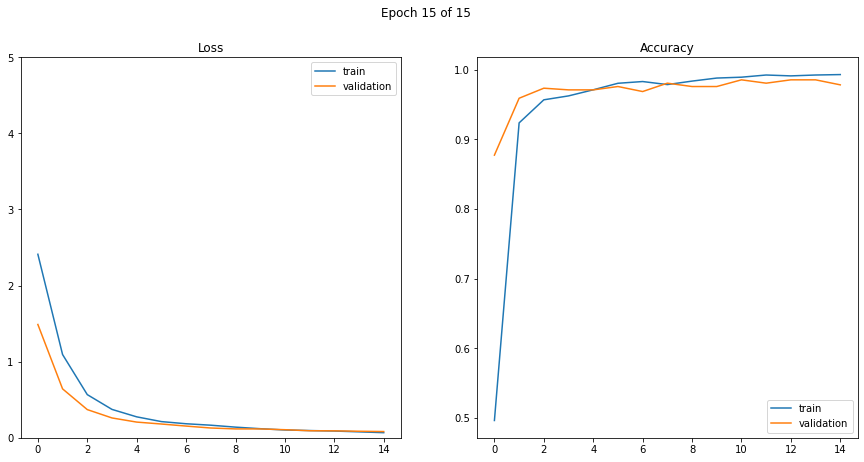

In [17]:
product_to_real.train(True, True)

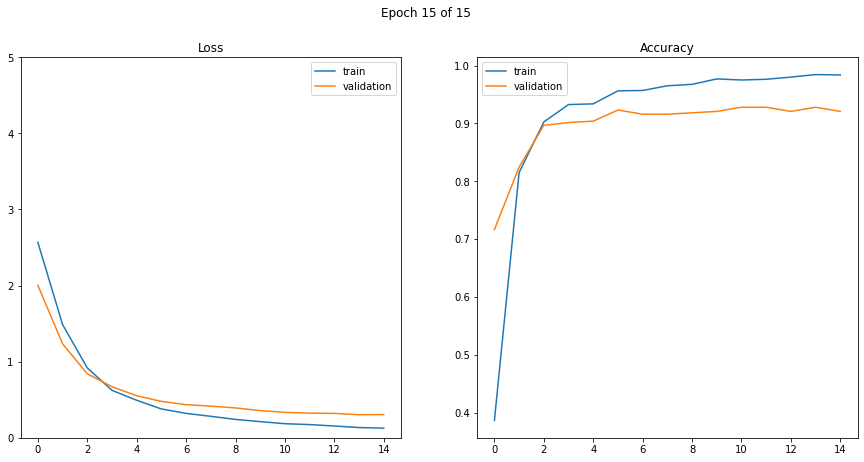

In [18]:
real_to_product.train(True, True)

### Test phase

In [19]:
product_to_real.model.eval()
real_to_product.model.eval()

acc_p_r, features_p_r, predictions_p_r, reals_p_r = product_to_real.test(use_target_dataset=True)
acc_p_p, features_p_p, predictions_p_p, reals_p_p = product_to_real.test(use_target_dataset=False)
acc_r_r, features_r_r, predictions_r_r, reals_r_r = real_to_product.test(use_target_dataset=False)
acc_r_p, features_r_p, predictions_r_p, reals_r_p = real_to_product.test(use_target_dataset=True)

accuracy = pd.DataFrame(
    columns=["P -> P", "R -> R", "P -> R", "R -> P"],
    index=["Baseline"]
)

accuracy.loc["Baseline"] = [
    acc_p_p,
    acc_r_r,
    acc_p_r,
    acc_r_p,
]
accuracy

,P -> P,R -> R,P -> R,R -> P
Baseline,0.9775,0.92,0.8525,0.9275


In [28]:
import pickle

data = {
    'features': {
        'pr': features_p_r,
        'pp': features_p_p,
        'rr': features_r_r,
        'rp': features_r_p,
    },
    'predictions': {
        'pr': predictions_p_r,
        'pp': predictions_p_p,
        'rr': predictions_r_r,
        'rp': predictions_r_p,
    },
    'reals': {
        'pr': reals_p_r,
        'pp': reals_p_p,
        'rr': reals_r_r,
        'rp': reals_r_p,
    }
}

torch.save(data, "baseline.pkl")

### Parameters optimization

In [22]:
baseline_comparison = pd.DataFrame([
    ["resize_256_256", *[0.9675, 0.92, 0.8325, 0.93]],
    ["resize_256", *[0.9675, 0.92, 0.8525, 0.92]],
    ["resize_256_256_auto_aug", *[0.96, 0.92, 0.8075, 0.925]],
    ["resize_256_256_rand_aug", *[0.9625, 0.915, 0.8525, 0.925]],
    ["resize_256_256_rand_aug_LRScheduler_10step", *[0.96, 0.9075, 0.8375, 0.9375]],
    ],
    columns=["transformation", "P -> P", "R -> R", "P -> R", "R -> P"],
)
baseline_comparison

,transformation,P -> P,R -> R,P -> R,R -> P
0,resize_256_256,0.9675,0.9200,0.8325,0.9300
1,resize_256,0.9675,0.9200,0.8525,0.9200
2,resize_256_256_auto_aug,0.9600,0.9200,0.8075,0.9250
3,resize_256_256_rand_aug,0.9625,0.9150,0.8525,0.9250
4,resize_256_256_rand_aug_LRScheduler_10step,0.9600,0.9075,0.8375,0.9375


## CORAL loss

The CORAL loss is an unsupervised domain adaptation technique used to align the covariances of two domains:

$$
\begin{equation}
l_{\text{CORAL}} = \frac{1}{4d^2} || C_S - C_T ||^2_F
\end{equation}
$$

where $||\cdot||^2_F$ is the square matrix Frobenius norm.

The covariance matrices $C_S$ and $C_T$, respectively for source and target domains, can be obtained from the following equations:

$$
\begin{equation}
C_S = \frac{1}{n_s - 1}\left(D_S^TD_S - \frac{1}{n_s}(1^TD_S)^T(1^TD_S)\right)\\
C_T = \frac{1}{n_t - 1}\left(D_T^TD_T - \frac{1}{n_t}(1^TD_T)^T(1^TD_T)\right)
\end{equation}
$$

where $n_s, n_t$ are the number of samples in the batch for source and target domains and $D_S,D_T$ are the extracted features from the model.

The CORAL loss is combined with the Cross Entropy loss as a regularizer:

$$
\begin{equation}
\text{loss} = l_{\text{CrossEntropy}} + \alpha * l_{\text{CORAL}}
\end{equation}
$$

Given the fact that the two loss components differ by three orders of magnitude, many values ahve been tested for the $\alpha$ parameter:

TODO: aggiungere l'immagine sotto

As long as the value is not too much large, the results are quite similar and the general behavior is comparable with the baseline model.

In general, we think that the approach of the coral loss could have some impact in the score, but in this the case the covariances of the two datasets are not enough big.

In [14]:
class Coral(Baseline):
    """
    Coral solver for the domain adaptation task, that inherits from the Baseline solver.
    """
    def _compute_domain_adaptation_loss(
        self,
        features_source: torch.tensor,
        features_target: torch.tensor,
    ) -> Optional[float]:
        """
        Returns the coral loss for domain adaptation
        
        Parameters
        ----------
        features_source: torch.tensor
            features extracted by the model on the source domain
        features_target: torch.tensor
            features extracted by the model on the target domain
        
        Returns
        ----------
        float:
            coral loss
        """
        source = features_source.double()
        target = features_target.double()

        n_features = source.data.shape[1]
        n_sample_source, n_sample_target = source.data.shape[0], target.data.shape[0]
        
        source_mean = torch.mean(source, 0, keepdim=True) - source
        source_covariance = source_mean.t() @ source_mean / (n_sample_source - 1)
        target_mean = torch.mean(target, 0, keepdim=True) - target
        target_covariance = target_mean.t() @ target_mean / (n_sample_target - 1)

        # frobenius norm between source and target
        loss = torch.mul((source_covariance - target_covariance), (source_covariance - target_covariance))
        loss = torch.sum(loss) / (4*n_features*n_features)
        return loss

### Train phase

In [15]:
set_random_seed(33)
num_threads = 6

num_epochs = 15
batch_size = 32
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20
coral_weight = 21

criterion = nn.CrossEntropyLoss()
product_to_real = Coral(
    product_path,
    real_path,
    split_rule,
    num_epochs,
    batch_size,
    criterion,
    lr,
    weight_decay,
    momentum,
    num_threads,
    "coral",
    "resnet50_pr",
    coral_weight,
)
real_to_product = Coral(
    real_path,
    product_path,
    split_rule,
    num_epochs,
    batch_size,
    criterion,
    lr,
    weight_decay,
    momentum,
    num_threads,
    "coral",
    "resnet50_rp",
    coral_weight,
)

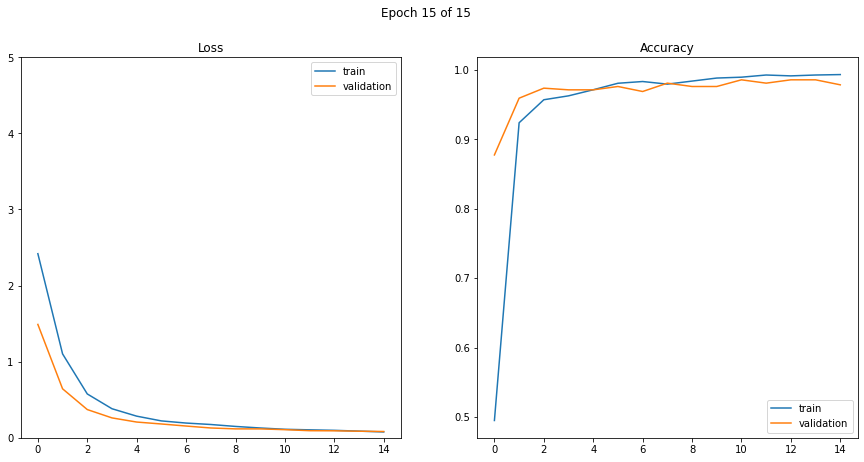

In [16]:
product_to_real.train(True, True)

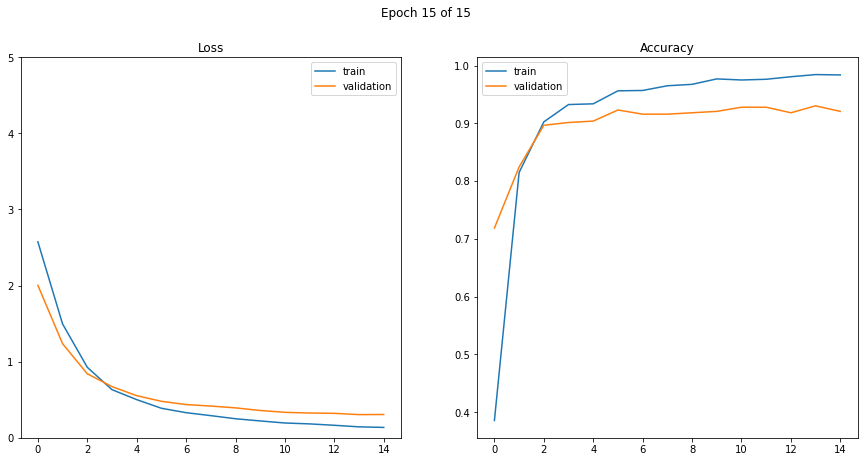

In [17]:
real_to_product.train(True, True)

### Test phase

In [18]:
product_to_real.model.eval()
real_to_product.model.eval()

acc_p_r, features_p_r, predictions_p_r, reals_p_r = product_to_real.test(use_target_dataset=True)
acc_p_p, features_p_p, predictions_p_p, reals_p_p = product_to_real.test(use_target_dataset=False)
acc_r_r, features_r_r, predictions_r_r, reals_r_r = real_to_product.test(use_target_dataset=False)
acc_r_p, features_r_p, predictions_r_p, reals_r_p = real_to_product.test(use_target_dataset=True)

accuracy = pd.DataFrame(
    columns=["P -> P", "R -> R", "P -> R", "R -> P"],
    index=["Coral"]
)

accuracy.loc["Coral"] = [
    acc_p_p,
    acc_r_r,
    acc_p_r,
    acc_r_p,
]
accuracy

,P -> P,R -> R,P -> R,R -> P
Coral,0.9775,0.92,0.85,0.9275


In [19]:
import pickle

data = {
    'features': {
        'pr': features_p_r,
        'pp': features_p_p,
        'rr': features_r_r,
        'rp': features_r_p,
    },
    'predictions': {
        'pr': predictions_p_r,
        'pp': predictions_p_p,
        'rr': predictions_r_r,
        'rp': predictions_r_p,
    },
    'reals': {
        'pr': reals_p_r,
        'pp': reals_p_p,
        'rr': reals_r_r,
        'rp': reals_r_p,
    }
}

torch.save(data, "coral.pkl")

### Parameters optimization

In [44]:
coral_comparison = pd.DataFrame(
    [[1,  *[0.9725,0.925,0.8325,0.925]],
    #[2,   *[0.955,0.91,0.81,0.9325]],
    [3,   *[0.9725,0.9325,0.835,0.925]],
    #[4,   *[0.9675,0.925,0.845,0.92]],
    #[5,   *[0.9775,0.9225,0.8425,0.9275]],
    [6,   *[0.9675,0.9175,0.84,0.9375]],
    #[7,   *[0.9575,0.89,0.84,0.9475]],
    #[8,   *[0.97,0.895,0.8475,0.9225]],
    [9,   *[0.9675,0.8925,0.8125,0.92]],
    #[10,  *[0.9675,0.915,0.81,0.915]],
    #[11,  *[0.97,0.91,0.8175,0.9175]],
    [12,  *[0.9625,0.915,0.8175,0.95]],
    #[13,  *[0.9725,0.915,0.805,0.9325]],
    #[14,  *[0.975,0.89,0.825,0.9275]],
    [15,  *[0.96,0.9075,0.8075,0.92]],
    #[16,  *[0.9575,0.9075,0.84,0.9175]],
    #[17,  *[0.975,0.91,0.79,0.935]],
    [18,  *[0.9625,0.9325,0.8275,0.9]],
    #[19,  *[0.96,0.895,0.8225,0.915]],
    #[20,  *[0.9675,0.9175,0.8075,0.9325]],
    [21,  *[0.985,0.915,0.86,0.935]],
    #[22,  *[0.9575,0.9,0.82,0.935]],
    #[23,  *[0.9675,0.8925,0.8425,0.9125]],
    [24,  *[0.97,0.9275,0.8275,0.9275]],
    #[25,  *[0.9525,0.9075,0.8325,0.915]],
    #[26,  *[0.9675,0.905,0.81,0.9375]],
    [27,  *[0.9725,0.8775,0.7975,0.8975]],
    #[28,  *[0.965,0.885,0.8225,0.9225]],
    [29,  *[0.96,0.9175,0.8275,0.935]],
    [100, *[0.9625,0.905,0.815,0.9075]],
    [200, *[0.955,0.905,0.75,0.8725]],
    [400, *[0.955,0.8975,0.7275,0.86]],
    [500, *[0.9525,0.8925,0.7175,0.865]],
    [600, *[0.95, 0.89, 0.705, 0.87]],
    [800, *[0.9425,0.88,0.6975,0.8625]],
    [1000,*[0.93, 0.865, 0.69, 0.8525]],],
    columns=["Coral weight", "P -> P", "R -> R", "P -> R", "R -> P"],
)
coral_comparison = coral_comparison.sort_values(["P -> R", "R -> P"], ascending=False)

<AxesSubplot:xlabel='Coral weight'>

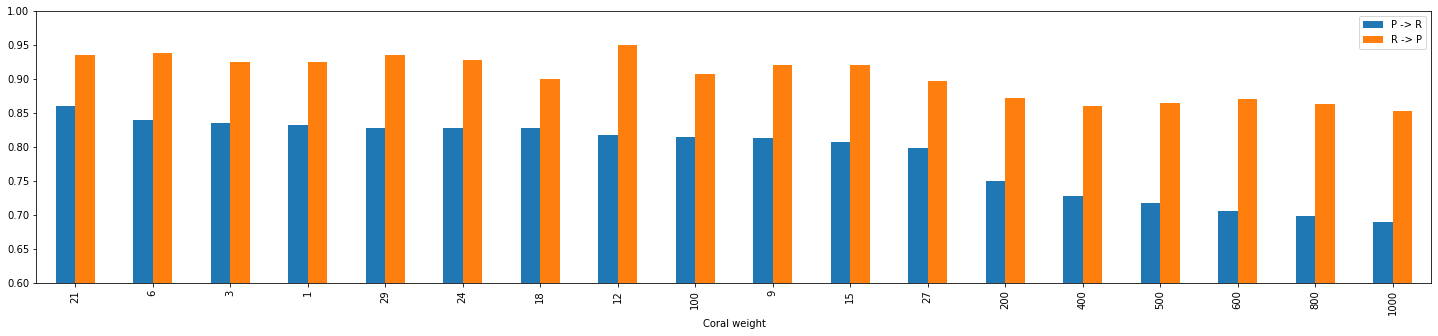

In [45]:
coral_comparison.set_index("Coral weight")[["P -> R", "R -> P"]].plot.bar(figsize=(25,5), ylim=[0.6, 1])

## Contrastive adaptation with unsupervised

### Contrastive Domain Discrepancy

$\require{color}$
*Contrastive Domain Discrepancy (CDD)* is a measure used to quantify the dissimilarity between classes with respect to source and target domains. The computation is made on features extracted from linear layers of the network after the pretrained backbone module.

\begin{equation}
e_1 = \sum_{i=1}^{n_s}\sum_{j=1}^{n_s} \frac{\mu_{c_1c_1}(y_i^s, y_j^s)k(\phi(x_i^s), \phi(x_j^s))} { \sum_{i=1}^{n_s}\sum_{j=1}^{n_s}\mu_{c_1c_1}(y_i^s, y_j^s)}
\end{equation}

\begin{equation}
e_2 = \sum_{i=1}^{n_t}\sum_{j=1}^{n_t} \frac{\mu_{c_2c_2}(y_i^t, y_j^t)k(\phi(x_i^t), \phi(x_j^t))} {\sum_{i=1}^{n_t}\sum_{j=1}^{n_t}\mu_{c_2c_2}(y_i^t, y_j^t)}
\end{equation}

\begin{equation}
e_3 = \sum_{i=1}^{n_s}\sum_{j=1}^{n_t} \frac{\mu_{c_1c_2}(y_i^s, y_j^t)k(\phi(x_i^s), \phi(x_j^t))} {\sum_{i=1}^{n_s}\sum_{j=1}^{n_t}\mu_{c_1c_2}(y_i^s, y_j^t)}
\end{equation}

Suppose the two following tables contain the outputs of the last two linear layers of the network for the source dataset with a batch size equal to 5; the layer sizes are respectively 5 for the first and to 3 for the second: rows represent samples, and columns are the features.

$$
\begin{array}{|c|c|c|c|c|}
    \hline
    0.496257 & 0.768222 & 0.0884774 & 0.13203  & 0.307423 \\
    \hline
    0.634079 & 0.490093 & 0.896445  & 0.455628 & 0.632306 \\
    \hline
    0.348893 & 0.401717 & 0.0223258 & 0.168859 & 0.293888 \\
    \hline
    0.518522 & 0.697668 & 0.800011  & 0.161029 & 0.282269 \\
    \hline
    0.681609 & 0.915194 & 0.3971    & 0.874156 & 0.419408 \\
    \hline
\end{array}\quad\quad
\begin{array}{|c|c|c|c|c|}
    \hline
    0.552907 & 0.952738  & 0.0361648 \\
    \hline
    0.185231 & 0.373417  & 0.3051    \\
    \hline
    0.932    & 0.17591   & 0.269834  \\
    \hline
    0.15068  & 0.0317195 & 0.20813   \\
    \hline
    0.929799 & 0.723109  & 0.742336  \\
    \hline
\end{array}
$$

Same for the target dataset with a batch size equal to 4.

$$
\begin{array}{|c|c|c|c|c|}
    \hline
    0.526296 & 0.243658 & 0.584592 & 0.0331526 & 0.138717 \\
    \hline
    0.242235 & 0.815469 & 0.793161 & 0.278252  & 0.481959 \\
    \hline
    0.81978  & 0.997067 & 0.698441 & 0.567546  & 0.835243 \\
    \hline
    0.205599 & 0.593172 & 0.112347 & 0.153457  & 0.241708 \\
    \hline
\end{array}\quad\quad
\begin{array}{|c|c|c|c|c|}
\hline
0.726237 & 0.70108  & 0.203824 \\
\hline
0.651054 & 0.774486 & 0.436891 \\
\hline
0.519091 & 0.615852 & 0.810188 \\
\hline
0.980097 & 0.114688 & 0.316765 \\
\hline
\end{array}
$$

In these matrices, samples are ordered according to their respective class.

For each one of the two domains, it is also required a list describing the number of samples for each class: the *i*-th value of the list represents the number of samples for the class *i*.
In this case, we have $[2,2,1]$ for the source dataset and $[1, 1, 2]$ for the target dataset: note that both lists sum up respectively to 5 and 4, which are the sizes of the two minibatches.

#### Distance computation
The first step is to compute distances among:

- source/source dataset
- target/target dataset
- source/target dataset

All these three distances are computed for the output of each of the two linear layers, aggregating for the different number of features summing them (`compute_pairwise_distance` function).

Obtained result for distance source/target with shape equal to `[batch size source X batch size target]`:

$$
\begin{array}{cc}
Layer 1& Layer2 \\
\begin{array}{|c|c|c|c|c|}
\hline
 0.560438 & 0.615181 & 0.997362 & 0.120472  \\
 \hline
 0.591715 & 0.324145 & 0.384421 & 1.0529    \\
 \hline
 0.415092 & 0.82409  & 1.48532  & 0.0682521 \\
 \hline
 0.28955  & 0.143876 & 0.66175  & 0.583425  \\
 \hline
 1.29631  & 0.718872 & 0.383529 & 0.962352  \\
 \hline
\end{array}&
\begin{array}{|c|c|c|c|c|}
\hline
 0.121484 & 0.201988 & 0.713748 & 0.963555   \\
 \hline
 0.410307 & 0.395216 & 0.425351 & 0.698889   \\
 \hline
 0.3225   & 0.465132 & 0.656027 & 0.00826399 \\
 \hline
 0.779328 & 0.854408 & 0.839412 & 0.706618   \\
 \hline
 0.331919 & 0.173635 & 0.184789 & 0.553817   \\
\hline
\end{array}
\end{array}
$$

The output for source/source and target/target has respectively shape of `[batch size source X batch size source]` and `[batch size target X batch size target]`. Distances within the same dataset (source/source, target/target) require an extra step that iterates in the distance matrix over the diagonal, extracting square submatrices that contain all distances from samples belonging the same class. Obtained result for one layer of source/source distance (given distribution $[2,2,1]$):

$$
\begin{array}{ccc}
Class1&Class2&Class3  \\
\begin{array}{|c|c|}
\hline
 0        & 0.543124 \\
 \hline
 0.543124 & 0        \\
\hline
\end{array}&
\begin{array}{|c|c|}
\hline
 0       & 0.63506 \\
 \hline
 0.63506 & 0       \\
\hline
\end{array}&
\begin{array}{|c|c|}
\hline
 0 \\
\hline
\end{array}
\end{array}
$$

The distance matrix source/target is averaged over classes submatrices (colors are used to highlight class groups) creating a new mean matrix:

$$
\begin{array}{cc}
\text{Layer1 before the average}&\text{Layer1 after}\\
\begin{array}{|c|c|c|c|c|}
\hline
 \color{red}{0.560438} & \color{green}{0.615181} & \color{orange}{0.99736} & \color{orange}{0.120472}  \\
 \hline
 \color{red}{0.591715} & \color{green}{0.324145} & \color{orange}{0.384421} & \color{orange}{1.0529}    \\
 \hline
 \color{magenta}{0.415092 }& \color{brown}{0.82409  }& \color{olive}{1.48532  }& \color{olive}{0.0682521} \\
 \hline
 \color{magenta}{0.28955  }& \color{brown}{0.143876 }& \color{olive}{0.66175  }& \color{olive}{0.583425 } \\
 \hline
 \color{pink}{1.29631  }& \color{darkgrey}{0.718872 }& \color{teal}{0.383529 }& \color{teal}{0.962352 } \\
 \hline
\end{array}&
\begin{array}{|c|c|c|c|c|}
\hline
 \color{red}{0.511834} & \color{green}{0.476363} & \color{orange}{0.607436} & \color{orange}{0.607436} \\
 \hline
 \color{red}{0.511834} & \color{green}{0.476363} & \color{orange}{0.607436} & \color{orange}{0.607436} \\
 \hline
 \color{magenta}{0.432476 }& \color{brown}{0.397005 }& \color{olive}{0.567757 }& \color{olive}{0.567757 }\\
 \hline
 \color{magenta}{0.432476 }& \color{brown}{0.397005 }& \color{olive}{0.567757 }& \color{olive}{0.567757 }\\
 \hline
 \color{pink}{0.280219 }& \color{darkgrey}{0.307591 }& \color{teal}{0.655509 }& \color{teal}{0.655509 }\\
 \hline
\end{array}
\end{array}
$$

The computation of the mean subregions is also applied to source/source and target/target data.

#### Kernel computation
Distances and mean matrices are then used to compute a kernel for each layer, and the list of results are summed up. The final matrix has a shape of `[number of samples X number of samples]` and expresses the correlation between samples taken into consideration (in the following table source/target table is presented):

$$
\begin{array}{|c|c|c|}
\hline
 3.92554 & 3.90333 & 3.65386 \\
 \hline
 3.52906 & 3.25892 & 4.40912 \\
 \hline
 0.74786 & 2.26064 & 4.51405 \\
 \hline
\end{array}
$$

#### Maximum Mean Discrepancy (MMD) computation
The three kernels extracted from source/source, targe/target and source/target are composed together to obtaind the MMD:

MMD formulas
\begin{align}
\hat{\mathcal{D}}^{mmd}_{l} &= \frac{1}{n_s^2}\sum_{i=1}^{n_s}\sum_{j=1}^{n_s}k_l(\phi_l(x_i^s), \phi_l(x_j^s)) \\
& + \frac{1}{n_t^2}\sum_{i=1}^{n_t}\sum_{j=1}^{n_t}k_l(\phi_l(x_i^t), \phi_l(x_j^t)) \\
& - \frac{1}{n_s n_t}\sum_{i=1}^{n_t}\sum_{j=1}^{n_t}k_l(\phi_l(x_i^s), \phi_l(x_j^t))
\end{align}

The result is:

$$
\begin{array}{|c|c|c|}
\hline
  8.30697 &  8.33474 & 4.42708 \\
  \hline
  9.13727 &  9.64986 & 3.07151 \\
  \hline
 18.5041  & 15.4785  & 7.26769 \\
 \hline
\end{array}
$$

where the diagonal represents the intra class discrepancy and the rest of the matrix the inter class discrepancy.

$$
\begin{array}{cc}
\text{Intra class elements}&\text{inter class elements}\\
\begin{array}{|c|c|c|}
\hline
  8.30697 &  \color{lightgrey}{8.33474} & \color{lightgrey}{4.42708} \\
  \hline
  \color{lightgrey}{9.13727} &  9.64986 & \color{lightgrey}{3.07151} \\
  \hline
  \color{lightgrey}{18.5041}  & \color{lightgrey}{15.4785}  & 7.26769 \\
 \hline
\end{array}&
\begin{array}{|c|c|c|}
\hline
  \color{lightgrey}{8.30697} &  8.33474 & 4.42708 \\
  \hline
  9.13727 &  \color{lightgrey}{9.64986} & 3.07151 \\
  \hline
 18.5041  & 15.4785  & \color{lightgrey}{7.26769} \\
 \hline
\end{array}
\end{array}
$$

#### CDD, intra class, infra class computation
The intra and inter class measures can be computed averaging over vectors of the previous step. The CDD instead can be obtained applying the following formula:

\begin{align}
\hat{\mathcal{D}}^{cdd}_{l} &= \underbrace{\frac{1}{M}\sum_{c=1}^M\hat{\mathcal{D}}^{cc}(\hat{y}_{1:n_t}^t, \phi)}_\text{intra class} \\
&- \underbrace{\frac{1}{M(M -1)} \sum_{c=1}^M\sum_{c'=1\\c'\ne c}^M\hat{\mathcal{D}}^{cc'}(\hat{y}_{1:n_t}^t, \phi)}_\text{inter class}
\end{align}


In [14]:
from typing import Tuple, List, Dict, Optional

class ConstrativeDomainDiscrepancy:
    """
    Compute the contrastive domain discrepancy loss
    """
    def __init__(
        self,
        num_layers: int,
        kernel_orders: Tuple[int],
        kernel_multipliers: Tuple[int],
        num_classes: int,
        device: torch.device
    ):
        self.num_layers = num_layers
        self.kernel_orders = kernel_orders
        self.kernel_multipliers = kernel_multipliers
        self.num_classes = num_classes
        self.device = device
        
        assert num_layers == len(kernel_orders) == len(kernel_multipliers), "There must be one kernel order and multiplier for each layer"
    
    def activate(
        self,
        source_layers_out: List[torch.Tensor], # shape: [num_layers X batch_size_source X output_of_layer(i)]
        target_layers_out: List[torch.Tensor], # shape: [num_layers X batch_size_target X output_of_layer(i)]
        samples_for_class_source: List[int], # shape: [num_classes]
        samples_for_class_target: List[int], # shape: [num_classes] 
    ) -> Dict[str, float]:
        """
        Returns CDD, intra and inter class losses.
        
        Parameters
        ----------
        source_layers_out: List[torch.Tensor]
            features produced by the model on the source domain
        target_layers_out: List[torch.Tensor]
            features produced by the model on the target domain
        samples_for_class_source: List[int]
            class distribution across source samples
        samples_for_class_target: List[int]
            class distribution across target samples

        Returns
        ----------
        Dict[str, float]
            CDD, intra and inter class losses.
        """
        assert len(source_layers_out) == len(target_layers_out) == self.num_layers, "number of layers must be the same"

        layers_dist = []
        layers_mean = []
        for src, trg in zip(source_layers_out, target_layers_out):
            layer_distances, layer_mean_distances = self.activate_layer(
                src,
                trg,
                samples_for_class_source,
                samples_for_class_target
            )
            layers_dist.append(layer_distances)
            layers_mean.append(layer_mean_distances)
            
        for i in range(self.num_layers):
            for c in range(len(samples_for_class_source)):
                # shape goes from [num_classes] to [num_classes X 1 X 1]
                layers_mean[i]['ss'][c] = layers_mean[i]['ss'][c].view(
                    len(samples_for_class_source), 1, 1
                )
                layers_mean[i]['tt'][c] = layers_mean[i]['tt'][c].view(
                    len(samples_for_class_source), 1, 1
                )
        
        class_kernel_dist = self.classes_mean_kernel(
            samples_for_class_source,
            samples_for_class_target,
            self.compute_cum_kernel_dist(
                [i['st'] for i in layers_dist],
                [i['st'] for i in layers_mean]
            )
        )
        
        cum_kernel_dist_ss = []
        cum_kernel_dist_tt = []
        for class_index in range(len(samples_for_class_source)):
            cum_kernel_dist_ss.append(
                torch.mean(
                    self.compute_cum_kernel_dist(
                        [i['ss'] for i in layers_dist],
                        [i['ss'] for i in layers_mean],
                        class_index
                    ).view(len(samples_for_class_source), -1), dim=1
                )
            )
            cum_kernel_dist_tt.append(
                torch.mean(
                    self.compute_cum_kernel_dist(
                        [i['tt'] for i in layers_dist],
                        [i['tt'] for i in layers_mean],
                        class_index
                    ).view(len(samples_for_class_source), -1), dim=1
                )
            )
        kernel_dist_ss = torch.stack(cum_kernel_dist_ss, dim=0)
        # understand why transpose here
        kernel_dist_tt = torch.stack(cum_kernel_dist_tt, dim=0).transpose(1, 0)
        
        mmds = kernel_dist_ss + kernel_dist_tt - 2 * class_kernel_dist
        
        intra_mmds = torch.diag(mmds, 0)
        intra = torch.sum(intra_mmds) / self.num_classes
        
        inter = None
        # trick to create a mask to exclude diagonal like
        # False True True
        # True False True
        # True True False
        inter_mask = (torch.ones([len(samples_for_class_source), len(samples_for_class_source)]).to(self.device) - \
            torch.eye(len(samples_for_class_source)).to(self.device)).type(torch.bool)
        inter_mmds = torch.masked_select(mmds, inter_mask)
        # inter is a flatten of all cells except the diagonal
        inter = torch.sum(inter_mmds) / (self.num_classes * (self.num_classes - 1))
        
        cdd = intra - inter
        return {
            'cdd': cdd,
            'intra': intra,
            'inter': inter
        }

        
    def activate_layer(
        self,
        source_features: torch.Tensor, # shape: [batch_size_source X output_of_layer(i)]
        target_features: torch.Tensor, # shape: [batch_size_target X output_of_layer(i)]
        samples_for_class_source: List[int], # shape: [num_classes]
        samples_for_class_target: List[int], # shape: [num_classes] 
    ):
        assert len(samples_for_class_source) == len(samples_for_class_target), "number of classes must be the same"
        
        num_classes = len(samples_for_class_source)
        
        # ss means source, source
        # tt means target, target
        # st means source, target
        distances = {}
        
        distances['ss'] = self.compute_pairwise_distance(source_features, source_features)
        distances['tt'] = self.compute_pairwise_distance(target_features, target_features)
        distances['st'] = self.compute_pairwise_distance(source_features, target_features)
        distances['ss'] = self.extract_classwise_information(
            distances['ss'],
            samples_for_class_source
        )
        distances['tt'] = self.extract_classwise_information(
            distances['tt'],
            samples_for_class_target
        )
        
        mean_distances = self.pairwise_class_mean_distance(
            samples_for_class_source,
            samples_for_class_target,
            distances
        )
        
        return distances, mean_distances
        
    def compute_pairwise_distance(
        self,
        ten1: torch.Tensor, # shape [batch_size_1 x features_length]
        ten2: torch.Tensor # shape [batch_size_2 x features_length]
    ) -> torch.Tensor: # shape [batch_size_1 x batch_size_2 x features_length]
        # batch_size 1 and 2 could be different
        assert ten1.shape[1] == ten2.shape[1], "Features length must be the same"
        batch_size_1 = ten1.shape[0]
        batch_size_2 = ten2.shape[0]
        
        features_length = ten1.shape[1]
        
        # goes from [batch_size_1 x features_length] to [batch_size_1 x batch_size_2 x features_length]
        expanded_1 = ten1.unsqueeze(1).expand(batch_size_1, batch_size_2, features_length)
        expanded_2 = ten2.unsqueeze(0).expand(batch_size_1, batch_size_2, features_length)
        
        # sum over the dimension 2 collases features
        # goes from [batch_size_1 x batch_size_2 x features_length] to [batch_size_1 x batch_size_2]
        squared_distance = ((expanded_1 - expanded_2)**2).sum(2)
        return squared_distance
    
    def extract_classwise_information(
        self,
        distance: torch.Tensor, # shape: [batch_size x batch_size]
        samples_for_class: List[int], # shape: [num_classes]
    ) -> List[torch.Tensor]:
        # the idea is to create one square submatrix for each class with side
        # equal to the amount of samples for that class inside the batch. In this way the
        # size of matrices will be proportional to the impact of it inside the batch_size
        square_submatrices_length = [length for length in samples_for_class]
        
        classes_distance = []
        x_offset = 0
        y_offset = 0
        for length in square_submatrices_length:
            class_distance = distance[x_offset:x_offset+length, y_offset:y_offset+length]
            classes_distance.append(class_distance)
            # translation over the diagonal of the matrix
            x_offset += length
            y_offset += length
        return classes_distance
    
    def pairwise_class_mean_distance(
        self,
        samples_for_class_source: List[int], # shape: [num_classes] 
        samples_for_class_target: List[int], # shape: [num_classes] 
        distances: Dict[str, torch.Tensor] # shape [batch_size_1 x batch_size_2 x features_length]
    ) -> Dict[str, torch.Tensor]:
        # patches will contain the square submatrices computed in extract_classwise_information
        patches = {}
        mean_distances = {}
        mean_distances['st'] = torch.zeros_like(distances['st'], requires_grad=False).to(self.device)
        mean_distances['ss'] = []
        mean_distances['tt'] = []
        for c in range(len(samples_for_class_source)):
            mean_distances['ss'] += [
                torch.zeros(
                    len(samples_for_class_source), requires_grad=False
                ).to(self.device)
            ]
            mean_distances['tt'] += [
                torch.zeros(
                    len(samples_for_class_source), requires_grad=False
                ).to(self.device)
            ]
        
        classes_distance = []
        source_start = 0
        source_end = 0
        for source_class_index in range(len(samples_for_class_source)):
            source_stard = source_end
            source_end = source_stard + samples_for_class_source[source_class_index]
            patches['ss'] = distances['ss'][source_class_index]
            
            target_start = 0
            target_end = 0
            for target_class_index in range(len(samples_for_class_target)):
                target_start = target_end
                target_end = target_start + samples_for_class_target[target_class_index]
                patches['tt'] = distances['tt'][target_class_index]
                
                patches['st'] = distances['st'][
                    source_start:source_start + samples_for_class_source[source_class_index],
                    target_start:target_start + samples_for_class_target[target_class_index]
                ]
                
                mean = self.mean_estimation(patches)
                
                mean_distances['ss'][source_class_index][target_class_index] = mean
                mean_distances['tt'][source_class_index][target_class_index] = mean
                mean_distances['st'][source_stard:source_end, target_start:target_end] = mean

        return mean_distances
    
    def mean_estimation(
        self,
        distances_patches: Dict[str, torch.Tensor]
    ) -> torch.Tensor:
        patches_sum = torch.sum(distances_patches['ss']) + \
            torch.sum(distances_patches['tt']) + \
            torch.sum(distances_patches['st'])
        
        batch_size_source = distances_patches['ss'].shape[0]
        batch_size_target = distances_patches['tt'].shape[0]
        
        # batch_size_source and batch_size_taret are removed in order
        # to obtain an unbiased estimator since total_amount_values
        # will be used as denominator for the mean computation
        total_amount_values = (batch_size_source * batch_size_source) + \
            (batch_size_target * batch_size_target) + \
            2 * (batch_size_source * batch_size_target) - \
            batch_size_source - batch_size_target
        
        mean = patches_sum.item() / total_amount_values
        return mean
    
    def compute_cum_kernel_dist(
        self,
        layer_dist_st: List[torch.Tensor], # shape: [batch_size_source X batch_size_target]
        layer_mean_st: List[torch.Tensor], # shape: [batch_size_source X batch_size_target]
        class_index: Optional[int]=None
    ):
        cum_kernel_dist = None
        for i, order, multiplier in zip(
            range(self.num_layers),
            self.kernel_orders,
            self.kernel_multipliers
        ):
            distance = layer_dist_st[i] if class_index is None else layer_dist_st[i][class_index]
            mean = layer_mean_st[i] if class_index is None else layer_mean_st[i][class_index]
            
            kernel_dist = self.compute_kernel_dist(distance, mean, order, multiplier)
            if cum_kernel_dist is None:
                cum_kernel_dist = kernel_dist
            else:
                cum_kernel_dist += kernel_dist
                
        return cum_kernel_dist
    
    # using the same kernel function from the original source code
    # https://github.com/kgl-prml/Contrastive-Adaptation-Network-for-Unsupervised-Domain-Adaptation/blob/39acc516231a35206eb6277e527ee08acfdd07a6/discrepancy/cdd.py#L73
    def compute_kernel_dist(
        self,
        distance: torch.Tensor, # shape: [batch_size_source X batch_size_target]
        mean: torch.Tensor, # shape: [batch_size_source X batch_size_target]
        kernel_order: int,
        kernel_multiplier: int
    ):
        base_mean = mean / (kernel_multiplier ** (kernel_order // 2))
        mean_list = [base_mean * (kernel_multiplier**i) for i in range(kernel_order)]
        mean_tensor = torch.stack(mean_list, dim=0).to(self.device)

        eps = 1e-5
        mean_mask = (mean_tensor < eps).type(torch.FloatTensor).to(self.device)
        mean_tensor = (1.0 - mean_mask) * mean_tensor + mean_mask * eps 
        mean_tensor = mean_tensor.detach()

        for i in range(len(mean_tensor.size()) - len(distance.size())):
            distance = distance.unsqueeze(0)

        distance = distance / mean_tensor
        upper_mask = (distance > 1e5).type(torch.FloatTensor).detach().to(self.device)
        lower_mask = (distance < 1e-5).type(torch.FloatTensor).detach().to(self.device)
        normal_mask = (1.0 - upper_mask - lower_mask)
        distance = (normal_mask * distance + upper_mask * 1e5 + lower_mask * 1e-5)
        kernel_val = torch.sum(torch.exp(-1.0 * distance), dim=0)
        return kernel_val
    
    def classes_mean_kernel(
        self,
        samples_for_class_source: List[int], # shape: [num_classes] 
        samples_for_class_target: List[int], # shape: [num_classes] 
        cumulate_kernel: torch.Tensor # shape: [batch_size_source X batch_size_target]
    ) -> torch.Tensor: # shape: [num_classes X num_classes]
        mean = torch.zeros(
            (len(samples_for_class_source), len(samples_for_class_source))
        ).to(self.device)
        x_start = 0
        x_end = 0
        for source_class_index in range(len(samples_for_class_source)):
            x_start = x_end
            x_end = x_start + samples_for_class_source[source_class_index]
            
            y_start = 0
            y_end = 0
            for target_class_index in range(len(samples_for_class_target)):
                y_start = y_end
                y_end = y_start + samples_for_class_target[target_class_index]
                
                class_mean = torch.mean(
                    cumulate_kernel[
                        x_start:x_start + samples_for_class_source[source_class_index],
                        y_start:y_start + samples_for_class_target[target_class_index]
                    ]
                )
                mean[source_class_index, target_class_index] = class_mean
        return mean

### Clustering

To be able to compute the Contrastive Domain Discrepancy (CCD), it is necessary to know the ground truth for both the source and target domains: for this reason, a clustering technique is needed to estimate target labels using the features extracted by the network on the target dataset. The paper proposes spherical kmeans for this task, which uses the *cosine distance* metric:

\begin{equation}
dist(a, b) = \frac{1}{2}\left(1 - \frac{\langle a, b \rangle}{\|a\| \|b\|}\right)
\end{equation}

Additionally, as reported in the paper, the number of cluster should be the number of classes in the source domain (which in this case is the same with respect to the target domain). Target centers should be initialized as the centers of the source domain.

During the iterative step of the spherical kmeans algorithm, the update of the target center of class *c* is performed as:

\begin{equation}
O^{tc} = \sum_{i=1}^{N_t}\textbf{1}_{\hat{y}_i^t=c} \frac{\phi_l (x_i^t)}{\| \phi_l (x_i^t)\|}
\end{equation}

according to

\begin{equation}
\textbf{1}_{\hat{y}_i^t=c} = 
    \begin{cases}
      1 & \textrm{if } \hat{y}_i^t=c \\
      0 & \textrm{otherwise}
    \end{cases}
\end{equation}

The iterative procedure is stopped when the mean distance of the centers computed by two adjacent iterations is below a certain threshold.

An additional step is performed to avoid ambiguous label assignments:
- each sample should have a distance to its assigned cluster below a certain threshold;
- each cluster should have assigned at least a certain amount of samples.

While in a first moment many classes could not be included, as the training proceeds the situation improves, since:
- the accuracy of the model increases;
- thanks to CCD, the intraclass domain discrepancy decreases and the interclass domain discrepancy increases.

In [15]:
from torch.nn.functional import normalize, one_hot

class Clustering:
    """
    Spherical KMeans clustering according to the cosine distance metric.
    Centroids are initialized with the classwise mean points from the source domain.
    """
    def __init__(
        self,
        batch_size: int,
        num_classes: int,
        stop_threshold: float,
        device: torch.device
    ):
        self.stop_threshold = stop_threshold
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.centers = None
        self.device = device
    
    def set_init_centers(
        self,
        features: torch.tensor, # shape: [num_samples X num_features]
        labels: torch.tensor # shape: [num_samples]
    ):
        """
        Initialize centroids by computing the classwise mean points of the source dataset
        
        Parameters
        ----------
        features: torch.tensor
            source domain features
        labels:
            source domain labels
        """
        self.init_centers = self.compute_centers(features, labels)
        self.centers = self.init_centers
        
    def compute_centers(
        self,
        features: torch.tensor, # shape: [num_samples X num_features]
        labels: torch.tensor # shape: [num_samples]
    ) -> torch.tensor:
        """
        Compute the centroids.
        
        Parameters
        ----------
        features: torch.tensor
            source domain features
        labels:
            source domain labels
            
        Returns
        ---------
        torch.tensor
            centroid for each class
        """
        centers = torch.zeros((self.num_classes, features.size(1))).to(self.device)
        for class_id in range(self.num_classes):
            class_sample_positions = (labels == class_id)
            centers[class_id] = torch.sum(features[class_sample_positions], dim=0)
        return centers
        
    def forward(
        self,
        features: torch.tensor, # shape: [num_samples X num_features]
    ) -> Tuple[torch.tensor, torch.tensor]: # shape: [num_samples] TODO update docs
        """
        Initialize the cyclic clustering procedure
        
        Parameters
        ----------
        features: torch.tensor
            target domain features
            
        Returns
        ----------
        torch.tensor:
            distances from centers for each feature vector
        torch.tensor:
            assigned label for each feature according to the minimum distance criterion
        """
        assert self.init_centers is not None, "initialize the centers of clusters"
        while True:
            centers = torch.zeros((self.num_classes, features.size(1))).to(self.device)
            class_counts = torch.zeros(self.num_classes).to(self.device)
            for start in range(0, features.size(0), self.batch_size):
                end = min(start + self.batch_size, features.size(0))
                batch = features[start:end]
                _, labels = self.classify_samples(batch)
                # labels_onehot shape: [batch_size X num_classes]
                labels_onehot = one_hot(labels, self.num_classes)

                class_counts += torch.sum(labels_onehot, dim=0)
                centers += self.compute_centers(batch, labels)

            # checks if one class has not any sample, in this way no update on those clusters
            mask = (class_counts.unsqueeze(1) > 0).float().to(self.device)
            centers = mask * centers + (1 - mask) * self.init_centers
            if self.check_stop_criterion(centers):
                break
            self.centers = centers
        self.centers = centers

        distances, labels = self.classify_samples(features)
        return distances, labels
        
        
    def classify_samples(
        self,
        features: torch.tensor # shape: [batch size X num_features]
    )-> Tuple[torch.tensor, torch.tensor]:
        """
        Returns distances and labels on model features
        
        Parameters
        ----------
        features: torch.tensor
            model features
            
        Returns
        ----------
        torch.tensor:
            distances from centers for each feature vector
        torch.tensor:
            assigned label for each feature according to the minimum distance criterion
        """
        distances = self.compute_cosine_distance(
            features,
            self.centers,
            cross=True
        )
        distances, labels = torch.min(distances, dim=1)

        return distances, labels
    
    def compute_cosine_distance(
        self,
        tensor_1: torch.tensor,
        tensor_2: torch.tensor,
        cross: bool
    ) -> torch.tensor:
        """
        Returns the cosine distance between two feature vectors (cross=False).
        Returns all the distances between two set of feature vectors (cross=True).
        
        Parameters
        ----------
        tensor_1: torch.tensor
            feature vector(s)
        tensor_2: torch.tensor
            feature vector(s)
            
        Returns
        ---------
        torch.tensor:
            cosine distances
        """
        tensor_1 = normalize(tensor_1, dim=1)
        tensor_2 = normalize(tensor_2, dim=1)
        if not cross:
            return 0.5 * (1.0 - torch.sum(tensor_1 * tensor_2, dim=1))
        else:
            assert(tensor_1.size(1) == tensor_2.size(1))
            return 0.5 * (1.0 - torch.matmul(tensor_1, tensor_2.transpose(0, 1)))

    def check_stop_criterion(self, centers: torch.tensor) -> bool:
        """
        Returns if the clustering process can be stopped if the average distance between the previous and current centers
        is below a certain threshold.
        
        Parameters
        ----------
        centers: torch.tensor
            new centers
            
        Returns
        ----------
        bool:
            True if the stopping criterion is met
        """
        distances = self.compute_cosine_distance(centers, self.centers, cross=False)
        distances = torch.mean(distances, dim=0)
        print('Clustering distance %.8f' % distances.item())
        return distances.item() < self.stop_threshold

### Train phase

In [16]:
class ContrastiveAdaptation(Baseline):
    """
    Contrastive Adaptation Network solver for the domain adaptation task, that inherits from the Baseline solver.
    """
    def __init__(
        self,
        source_path: str,
        target_path: str,
        split_rule: SplitRule,
        num_epochs: int,
        batch_size: int,
        criterion,
        lr: float,
        weight_decay: float,
        momentum: float,
        num_threads: int,
        domain_adaptation_loss_weight: float,
        num_features: int,
        batch_size_clustering: int,
        stop_threshold_clustering: float,
        threshold_clustering: float,
        min_samples_per_class: int,
        skipped_clustering_epochs: int,
        num_layers: int,
        kernel_orders: Tuple[int],
        kernel_multipliers: Tuple[int],
        classes_per_batch: int,
        best_model_path: str,
    ):
        self.device = get_device()
        self.source_path = source_path
        self.target_path = target_path   
        self.split_rule = split_rule
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = criterion
        self.num_threads = num_threads
        self.domain_adaptation_loss_weight = domain_adaptation_loss_weight
        self.num_features = num_features
        self.threshold_clustering = threshold_clustering
        self.min_samples_per_class = min_samples_per_class
        self.skipped_clustering_epochs = skipped_clustering_epochs
        self.classes_per_batch = classes_per_batch
        self.best_model_path = best_model_path
        
        self.dataloaders, self.source_test_dataset, self.target_test_dataset, self.num_classes = self._init_dataloaders()
        
        self.cdd = ConstrativeDomainDiscrepancy(
            num_layers,
            kernel_orders,
            kernel_multipliers,
            self.num_classes,
            self.device,
        )
        self.clustering = Clustering(
            batch_size_clustering,
            self.num_classes,
            stop_threshold_clustering,
            self.device,
        )
        self.model = DomainAdaptationModel(
            backbone_type="resnet50", 
            n_classes=self.num_classes,
            #n_feature_extracted=(num_features,)
        )
        self.model.to(self.device)
        self.optimizer = get_optimizer(self.model, lr, weight_decay, momentum, "Adam")
        
    def _init_dataloaders(self) -> Tuple[Dict[str, Dict[str, DataLoader]], SingleDataSourceDataset, SingleDataSourceDataset, int]:
        """
        Build the datasets and dataloaders for the training loop.
        
        Returns
        ----------
        Dict[str, Dict[str, DataLoader]]:
            dataloaders for train dataset (both source and target) and test dataset (just source) and clustering (both source and target)
        SingleDataSourceDataset:
            source test dataset
        SingleDataSourceDataset:
            target test dataset
        int:
            number of classes
        """
        source_train, source_test = get_split(self.source_path, self.split_rule, "source")
        target_train, target_test = get_split(self.target_path, self.split_rule, "target")
        dataloaders = {
            'train': {
                'source': get_data_loader(source_train, batch_size, num_threads),
                'target': get_data_loader(target_train, batch_size, num_threads),
            },
            'test': {
                'source': get_data_loader(source_test, batch_size, num_threads),
            },
            'clustering': {
                'source': source_train,
                'target': target_train,
            }
        }
        return dataloaders, source_test, target_test, source_train.num_classes
    
    @torch.no_grad()
    def clustering_initialization(self) -> None:
        """
        Initialize the clustering centers according to the source domain.
        """
        source_features = []
        source_labels = []
        dataset = self.dataloaders['clustering']['source']
        for image, label in dataset:
            image = image.to(self.device).unsqueeze(0)
            features, _ = self.model(image, dataset.get_name())
            source_features.append(features)
            source_labels.append(label)

        source_features = torch.cat(source_features)
        source_labels = torch.tensor(source_labels)

        self.clustering.set_init_centers(source_features, source_labels)
    
    @torch.no_grad()
    def clustering_inference(self, dataset_domain: str):
        """
        Perform clustering inference on a certain domain.

        Parameters
        ----------
        dataset_domain: str
            either 'source' or 'target'
            
        Returns
        ----------
        torch.tensor:
            distances from centers for each feature vector
        torch.tensor:
            assigned label for each feature according to the minimum distance criterion
        """
        features = []
        dataset = self.dataloaders['clustering'][dataset_domain]
        for image, _ in dataset:
            image = image.to(self.device).unsqueeze(0)
            fs, _ = self.model(image, dataset.get_name())
            features.append(fs)
        features = torch.cat(features)

        return self.clustering.forward(features)

    def filtering(
        self,
        predicted_labels: torch.tensor, # shape: [num_samples]
        clustering_distances: torch.tensor, # shape: [num_samples]
    ) -> Tuple[torch.tensor, torch.tensor]:
        """
        Filter clustering predictions based on the number of samples per class and the distance of each samples from its assigned centroid.
        
        Parameters
        ----------
        predicted_labels: torch.tensor
            predictions by the clustering algorithm
        clustering_distances: torch.tensor
            distances computed by the clustering algorithm

        Returns
        ----------
        torch.tensor
            single samples to ignore
        torch.tensor
            classes to ignore
        """
        clusters_to_delete = torch.argwhere(torch.bincount(predicted_labels.int()) < self.min_samples_per_class)
        filter_mask = torch.zeros(predicted_labels.shape, dtype=torch.bool)

        for i, (label, dist) in enumerate(zip(predicted_labels, clustering_distances)):
            if dist < self.threshold_clustering and label not in clusters_to_delete:
                filter_mask[i] = True

        return filter_mask, clusters_to_delete

    def train(self, validation_step: Optional[bool]=False, display_plot: Optional[bool]=False):
        """
        Start the training loop
        
        Parameters
        ----------
        validation_step: bool
            True if you want to include also the validation step in the loop
        display_plot: bool
            True if you want to produce plots that autorefresh at each epoch
        """
        best_acc = 0
        losses = {'train': [], 'validation': []}
        accs = {'train': [], 'validation': []}

        # start training loop
        for epoch in range(self.num_epochs):
            # apply the cluster only every self.skipped_clustering_epochs epochs
            if epoch % self.skipped_clustering_epochs == 0:
                self.model.eval()
                self.clustering_initialization()
                target_clustering_distances, target_clustering_labels = self.clustering_inference("target")
                filter_mask, clusters_to_delete = self.filtering(
                    target_clustering_labels,
                    target_clustering_distances,
                )
                # build the CAN dataloder which is going to be used for the next self.skipped_clustering_epochs epochs
                # it will include target labels as predicted by the clustering algorithm
                can_loader = DataLoader(
                    CANDataset(
                        self.dataloaders['train']['source'].dataset,
                        self.dataloaders['train']['target'].dataset,
                        self.batch_size // self.classes_per_batch,
                        self.classes_per_batch,
                        filter_mask.numpy(),
                        target_clustering_labels.cpu().detach().numpy(),
                    ),
                    batch_size=self.classes_per_batch,
                    shuffle=True,
                    drop_last=False,
                    collate_fn=CAN_collate_function
                )
                can_loader_iterator = iter(can_loader)

            # train the model
            self.model.train()
            epoch_ce_loss = 0.0
            epoch_cdd_loss = 0.0
            epoch_acc = 0.0
            with torch.set_grad_enabled(True):
                num_cdd_losses = 0
                for source_x, source_labels in self.dataloaders['train']['source']:
                    source_x = source_x.to(self.device)
                    source_labels = source_labels.to(self.device)
                    self.optimizer.zero_grad()

                    features, predictions = self.model(source_x)
                    source_x = source_x.detach().cpu()

                    ce_loss = self.criterion(predictions, source_labels)
                    predictions = predictions.detach().cpu()
                    source_labels = source_labels.detach().cpu()

                    epoch_ce_loss += ce_loss.item()
                    epoch_acc += (torch.argmax(predictions, 1) == source_labels).sum().item() / source_labels.size()[0]

                    ce_loss.backward()
                    
                    # check if the CAN dataset contains any available class
                    if (self.num_classes - len(clusters_to_delete)) >= self.classes_per_batch:
                        # the can dataloader can be consumed faster that the training source dataloader
                        try:
                            can_sample = next(can_loader_iterator)
                        except Exception:
                            can_loader_iterator = iter(can_loader)
                            can_sample = next(can_loader_iterator)

                        source_xs = can_sample['source_xs'].to(self.device)
                        source_ys = can_sample['source_ys'].to(self.device)
                        target_xs = can_sample['target_xs'].to(self.device)
                        target_ys = can_sample['target_ys_clustering'].to(self.device)

                        # computer features on both source and target domains
                        feature_source, _ = self.model(source_xs)
                        feature_target, _ = self.model(target_xs)
                        
                        # compute the distribution of the source labels and target labels (obtained by the clustering algorithm)
                        source_counts = list(torch.bincount(source_ys.int(), minlength=self.num_classes).detach().cpu().numpy())
                        target_counts = list(torch.bincount(target_ys.int(), minlength=self.num_classes).detach().cpu().numpy())
                        source_counts = list(filter(lambda x: x != 0, source_counts))
                        target_counts = list(filter(lambda x: x != 0, target_counts))

                        # compute the contrastive domain discrepancy loss
                        cdd_loss = self.cdd.activate(
                            [feature_source],
                            [feature_target],
                            source_counts,
                            target_counts
                        )

                        cdd_loss = cdd_loss['cdd']

                        cdd_loss *= 5  # weight of the CDD loss
                        cdd_loss.backward()
                        epoch_cdd_loss += cdd_loss.item()
                        num_cdd_losses += 1
                    else:
                        print("CDD has not been computed")

                    self.optimizer.step()

                epoch_ce_loss /= len(self.dataloaders['train']['source'])
                epoch_acc /= len(self.dataloaders['train']['source'])
                epoch_cdd_loss /= num_cdd_losses
                losses['train'].append(epoch_ce_loss)
                accs['train'].append(epoch_acc)

                print(f"{epoch_ce_loss=} {epoch_acc=} {epoch_cdd_loss=} {num_cdd_losses=}")

            if validation_step:
                # evaluate the model on the test dataset of the source domain
                self.model.eval()
                torch.set_grad_enabled(False)
                loss, acc = self._validation_step()
                losses['validation'].append(loss)
                accs['validation'].append(acc) 
                print(f"val loss: {loss} val acc: {acc}")
                if acc > best_acc:
                    print(f'saving best model at {epoch} epoch with acc {acc}')
                    torch.save(
                        {
                            'epoch': epoch,
                            'val_loss': loss,
                            'val_acc': acc,
                            'model': self.model.state_dict(),
                            'optimizer': self.optimizer.state_dict()
                        },
                        self.best_model_path
                    )
                    best_acc = acc
            if display_plot and validation_step:
                # display loss and accuracy plots, if requested
                print_epoch_chart(
                    losses['train'],
                    losses['validation'],
                    accs['train'],
                    accs['validation'],
                    epoch,
                    self.num_epochs
                )
            elif display_plot and not validation_step:
                print("WARNING: display_plot only allowed with validation_step sets to true")

In [17]:
"""
BEST MODEL CONFIGURATION WITH RESNET50 AS BACKBONE (DO NOT TOUCH)
# misc
set_random_seed(1)
num_threads = 12
num_features = 2048

# clustering
batch_size_clustering = 1000
stop_threshold_clustering = 0.00025
threshold_clustering = 1.0
min_samples_per_class_clustering = 6
skipped_clustering_epochs = 3

# ccd
num_layers = 1
kernel_orders = (5,)
kernel_multipliers = (2,)

# train
num_epochs = 50
batch_size = 128
classes_per_batch = 8
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20
"""

# misc
set_random_seed(2)
num_threads = 12
num_features = 2048

# clustering
batch_size_clustering = 1000
stop_threshold_clustering = 0.00025
threshold_clustering = 1.0
min_samples_per_class_clustering = 6
skipped_clustering_epochs = 3

# ccd
num_layers = 1
kernel_orders = (5,)
kernel_multipliers = (2,)

# train
num_epochs = 10
batch_size = 16
classes_per_batch = 4
lr = 0.001
weight_decay = 0.000001
momentum = 0.9
scheduler_factor = 0.25
scheduler_patience = 20

criterion = nn.CrossEntropyLoss()
product_to_real = ContrastiveAdaptation(
    product_path,
    real_path,
    split_rule,
    num_epochs,
    batch_size,
    criterion,
    lr,
    weight_decay,
    momentum,
    num_threads,
    0,
    num_features,
    batch_size_clustering,
    stop_threshold_clustering,
    threshold_clustering,
    min_samples_per_class_clustering,
    skipped_clustering_epochs,
    num_layers,
    kernel_orders,
    kernel_multipliers,
    classes_per_batch,
    BEST_PR_MODEL_PATH,
)
real_to_product = ContrastiveAdaptation(
    real_path,
    product_path,
    split_rule,
    num_epochs,
    batch_size,
    criterion,
    lr,
    weight_decay,
    momentum,
    num_threads,
    0,
    num_features,
    batch_size_clustering,
    stop_threshold_clustering,
    threshold_clustering,
    min_samples_per_class_clustering,
    skipped_clustering_epochs,
    num_layers,
    kernel_orders,
    kernel_multipliers,
    classes_per_batch,
    BEST_RP_MODEL_PATH,
)

In [ ]:
product_to_real.train(True, False)

In [ ]:
real_to_product.train(True, True)

### Test phase

In [18]:
checkpoint_pr = torch.load(BEST_PR_MODEL_PATH)
print(f'checkpoint at epoch {checkpoint_pr["epoch"]} with loss {checkpoint_pr["val_loss"]} and acc {checkpoint_pr["val_acc"]}')
product_to_real.model.load_state_dict(checkpoint_pr['model'])

checkpoint_rp = torch.load(BEST_RP_MODEL_PATH)
print(f'checkpoint at epoch {checkpoint_rp["epoch"]} with loss {checkpoint_rp["val_loss"]} and acc {checkpoint_rp["val_acc"]}')
real_to_product.model.load_state_dict(checkpoint_rp['model'])

product_to_real.model.eval()
real_to_product.model.eval()

acc_p_r, features_p_r, predictions_p_r, reals_p_r = product_to_real.test(use_target_dataset=True)
acc_p_p, features_p_p, predictions_p_p, reals_p_p = product_to_real.test(use_target_dataset=False)
acc_r_r, features_r_r, predictions_r_r, reals_r_r = real_to_product.test(use_target_dataset=False)
acc_r_p, features_r_p, predictions_r_p, reals_r_p = real_to_product.test(use_target_dataset=True)

accuracy = pd.DataFrame(
    columns=["P -> P", "R -> R", "P -> R", "R -> P"],
    index=["CDD"]
)

accuracy.loc["CDD"] = [
    acc_p_p,
    acc_r_r,
    acc_p_r,
    acc_r_p,
]
accuracy

checkpoint at epoch 38 with loss 0.07322317361831665 and acc 0.98046875
checkpoint at epoch 9 with loss 0.28304360806941986 and acc 0.935546875


,P -> P,R -> R,P -> R,R -> P
CDD,1.0,0.9825,0.86,0.96


In [19]:
import pickle

data = {
    'features': {
        'pr': features_p_r,
        'pp': features_p_p,
        'rr': features_r_r,
        'rp': features_r_p,
    },
    'predictions': {
        'pr': predictions_p_r,
        'pp': predictions_p_p,
        'rr': predictions_r_r,
        'rp': predictions_r_p,
    },
    'reals': {
        'pr': reals_p_r,
        'pp': reals_p_p,
        'rr': reals_r_r,
        'rp': reals_r_p,
    }
}

torch.save(data, "cdd.pkl")

## Conclusions

### Features
In this section, Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) is going to be used to inspect the goodness of the features extracted by the different models.
The UMAP algorithm reduces the feature vector from 2048 dimensions to just two, in order to obtain some points that can be plotted on a 2D plane.
The feature vectors are extracted from the test dataset of the target domain.

Some conclusions:
- P->R is worst that R->P not only in classification accuracy, but also on feature distribution;
- CDD is doing what it is supposed to do: minimize the intra class discrepancy and maximize the inter class discrepancy. In fact, cluster between different classes are quite far from each other;
- CDD relies on the clustering algorithm: in case it fails, the feature clusters may contain samples from different classes.

In [ ]:
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import umap

from sklearn.metrics import confusion_matrix

In [2]:
reducer = umap.UMAP()

In [3]:
baseline_data = torch.load('baseline.pkl')    
coral_data = torch.load('coral.pkl')
cdd_data = torch.load('cdd.pkl')

In [4]:
embedding_baseline_pr = reducer.fit_transform(baseline_data['features']['pr'].squeeze(1))
embedding_baseline_rp = reducer.fit_transform(baseline_data['features']['rp'].squeeze(1))

embedding_coral_pr = reducer.fit_transform(coral_data['features']['pr'].squeeze(1))
embedding_coral_rp = reducer.fit_transform(coral_data['features']['rp'].squeeze(1))

embedding_cdd_pr = reducer.fit_transform(cdd_data['features']['pr'].squeeze(1))
embedding_cdd_rp = reducer.fit_transform(cdd_data['features']['rp'].squeeze(1))

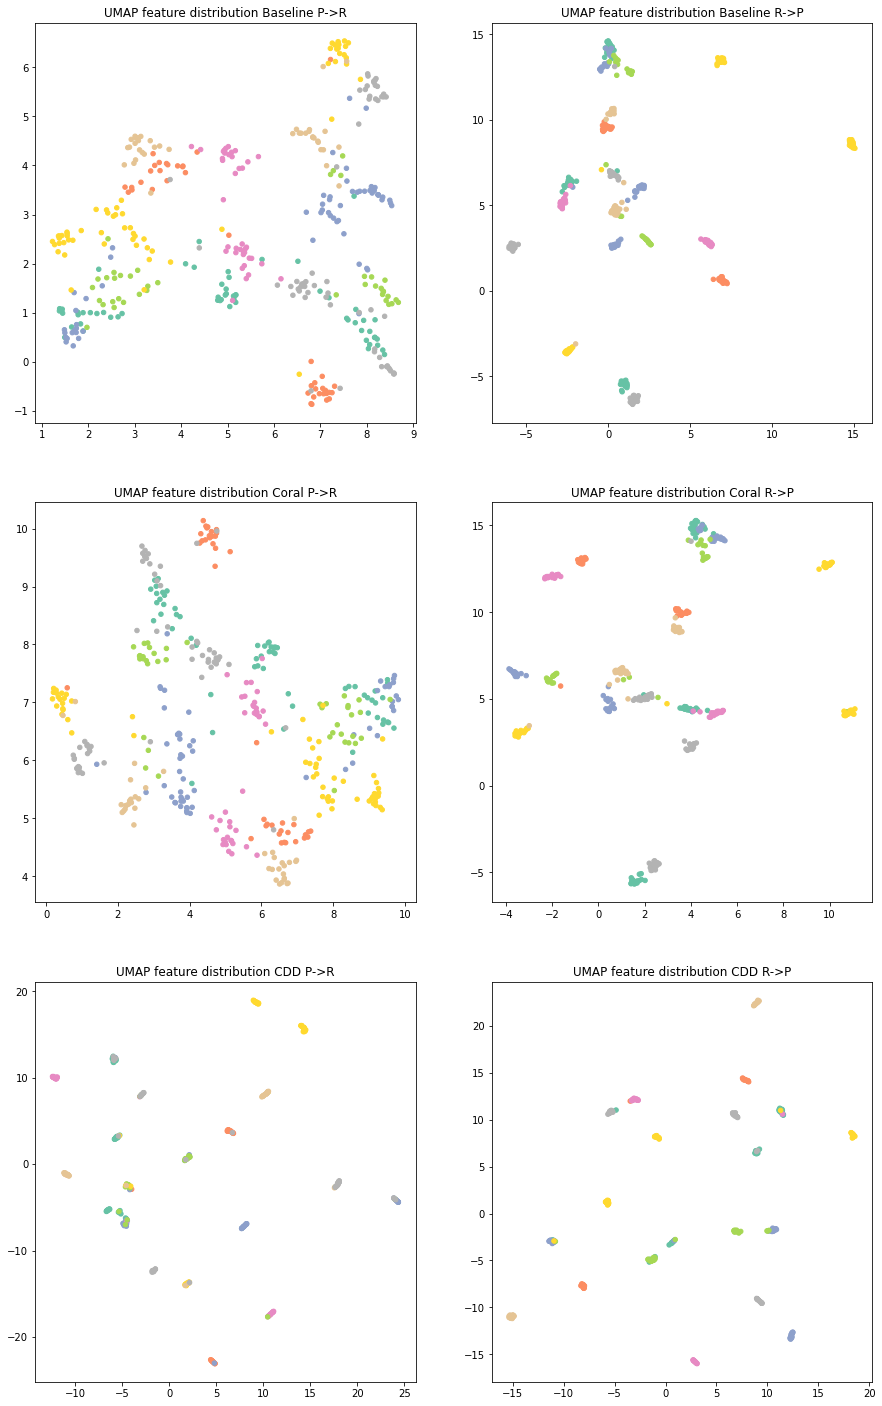

In [58]:
grid_emeddings = [
    [embedding_baseline_pr, embedding_baseline_rp],
    [embedding_coral_pr, embedding_coral_rp],
    [embedding_cdd_pr, embedding_cdd_rp],
]

grid_reals = [
    [baseline_data['reals']['pr'], baseline_data['reals']['rp']],
    [coral_data['reals']['pr'], coral_data['reals']['rp']],
    [cdd_data['reals']['pr'], cdd_data['reals']['rp']],
]

labels = [
    ["Baseline P->R", "Baseline R->P"],
    ["Coral P->R", "Coral R->P"],
    ["CDD P->R", "CDD R->P"],
]

fig, axes = plt.subplots(3, 2, figsize=(15, 25))

for row in range(3):
    for col in range(2):
        axes[row][col].scatter(
            grid_emeddings[row][col][:, 0],
            grid_emeddings[row][col][:, 1],
            c=grid_reals[row][col],
            s=20,
            cmap="Set2",
        )
        axes[row][col].set_title(f"UMAP feature distribution {labels[row][col]}")

plt.savefig("umaps.png")

### Confusion Matrices
Analyzing the confusion matrices, it is possible to note that some models struggle to classify some classes.
In some cases, this fact can be explained by the fact that objects are really similar between each other: for example bookcases are confused with fire cabinets by all models.
In other cases, the shapes the shapes of one class can recall another one: this is the case of cars jacks and helicopters.

In [39]:
cms = [
       [
           confusion_matrix(baseline_data['reals']['pr'], baseline_data['predictions']['pr']),
           confusion_matrix(baseline_data['reals']['rp'], baseline_data['predictions']['rp']),
       ],
        [
           confusion_matrix(coral_data['reals']['pr'], coral_data['predictions']['pr']),
           confusion_matrix(coral_data['reals']['rp'], coral_data['predictions']['rp']),
       ],
        [
           confusion_matrix(cdd_data['reals']['pr'], cdd_data['predictions']['pr']),
           confusion_matrix(cdd_data['reals']['rp'], cdd_data['predictions']['rp']),
       ],
]

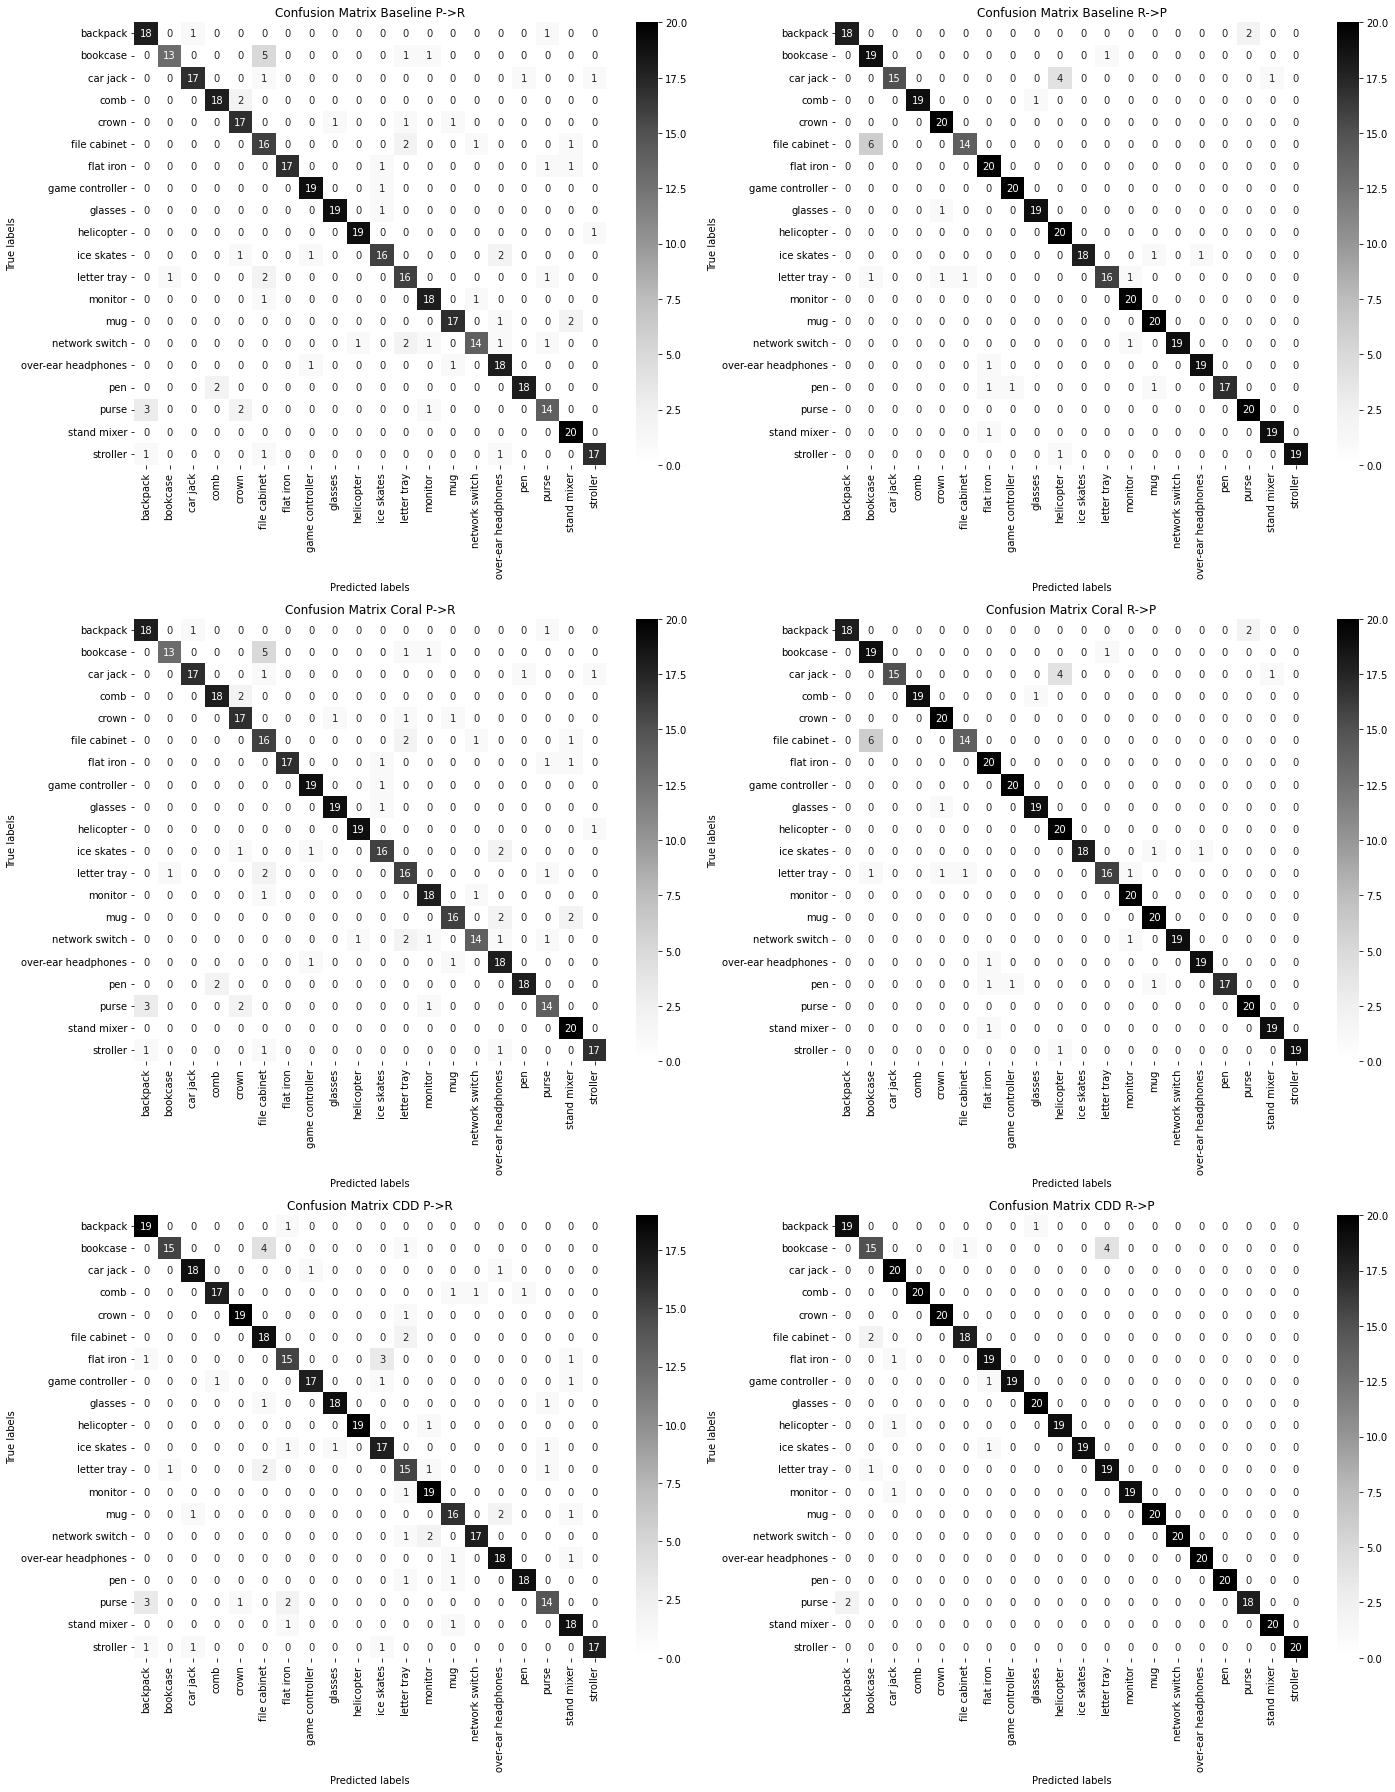

In [60]:
labels = [
    ["Baseline P->R", "Baseline R->P"],
    ["Coral P->R", "Coral R->P"],
    ["CDD P->R", "CDD R->P"],
]

fig, axes = plt.subplots(3, 2, figsize=(20, 25))

for row in range(3):
    for col in range(2):
        sns.heatmap(cms[row][col], annot=True, fmt='g', ax=axes[row][col], cmap='Greys')
        axes[row][col].set_xlabel('Predicted labels')
        axes[row][col].set_ylabel('True labels')
        axes[row][col].set_title(f"Confusion Matrix {labels[row][col]}")
        axes[row][col].xaxis.set_ticklabels(classes, rotation=90)
        axes[row][col].yaxis.set_ticklabels(classes, rotation=0)
fig.tight_layout()
plt.savefig("confusion_matrices.png")